# Assignment Overview
## Julia Antonioli, 60178

## Background Story  

In the ever-evolving landscape of e-commerce, understanding customer behavior has become a cornerstone of strategic marketing. An emerging e-commerce giant, "FarTrend," has experienced rapid growth by offering a wide range of products from fashion to electronics, catering to over 3400 customers across diverse demographics. Despite their success, FarTrend faces **challenges in personalizing marketing efforts and predicting future purchasing behavior**, crucial for sustaining growth and enhancing customer satisfaction.

## The Challenge

FarTrend's extensive customer database reveals purchasing patterns over the past year but lacks actionable insights to anticipate the needs of new customers. Traditional marketing strategies have yielded moderate success; however, the leadership team believes that a more data-driven approach could unlock exponential growth.

You are working on the marketing intelligence team! Your goal is to **develop a  machine learning model that segments FarTrend's customer base and predicts future purchases of new customers within their first year.** This model aims to transform FarTrend approach to customer engagement by delivering personalized marketing campaigns and tailored product recommendations.

## Data Description

The IT extracted a dataframe with the main transaction performed by the customers. 

##### Variables
InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name.

Quantity: The quantities of each product (item) per transaction. 

InvoiceDate: The day and time when each transaction was generated.

UnitPrice: Product price per unit.

CustomerID: Unique customer number. 

Country: The name of the country where each customer resides.

## Question 1: Data Quality and Customer Understanding (30 points)

#### Q1.1 Please perform the exploratory data analysis of the data. (20 points)


##### Import necessary libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

In [2]:
dataset = pd.read_excel("FarTrend_eRetail.xlsx")
df = pd.DataFrame(dataset)

##### Basic Understanding of the dataset

In [3]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
len(df)

541909

In [5]:
# Describe the dataset to get an initial understanding of what the numeric columns contain
df.describe().T

count                           mean                  min  \
Quantity     541909.0                        9.55225             -80995.0   
InvoiceDate    541909  2011-07-04 13:34:57.156386048  2010-12-01 08:26:00   
UnitPrice    541909.0                       4.611114            -11062.06   
CustomerID   406829.0                    15287.69057              12346.0   

                             25%                  50%                  75%  \
Quantity                     1.0                  3.0                 10.0   
InvoiceDate  2011-03-28 11:34:00  2011-07-19 17:17:00  2011-10-19 11:27:00   
UnitPrice                   1.25                 2.08                 4.13   
CustomerID               13953.0              15152.0              16791.0   

                             max          std  
Quantity                 80995.0   218.081158  
InvoiceDate  2011-12-09 12:50:00          NaN  
UnitPrice                38970.0    96.759853  
CustomerID               18287.0  1713.600303

In [6]:
# Describe the dataset to get an initial understanding of what the categorical columns contain
df.describe(include = "object").T

count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
Country      541909     38                      United Kingdom  495478

**OBSERVATIONS:**
- **Quantity**

> The average quantity of products per transaction is around 9.55, with a wide range spanning from -80995 to 80995. 

> It will be assumed that negative values signify returned or cancelled orders and will be addressed in following steps. 

> The considerable standard deviation suggests significant dispersion in the data, further emphasized by the substantial difference between the max and 75th percentile values (these could be outliers).


- **InvoiceDate**

> The max and min value show that we are looking at data in the one year range of December 2010 to December 2011.

> The spread seen in the percentiles show a fairly equal distribution of the data of the months.


- **UnitPrice**

> The average unit price of the products is 4.61, with a diverse range from -11062.06 to 38970. 

> In this case, the negative prices are assumed to present anomalies or noise in the data. 

> As with the Quantity column, the presence of outliers is highlighted by the substantial gap between the maximum and 75th percentile values.


- **CustomerID**

> The difference in count in comparison to the other features in the dataset suggest that there are missing values that require attention. 

> Customer IDs range from 12346 to 18287.


- **InvoiceNo**

> There are 25900 unique invoice numbers in comparison to the total count of rows (541909). This difference reflects that multiple products are usually ordered in the same transaction. 

> The invoice number 573585 is the order with the most amount of products bought in one transaction (1114).


- **StockCode**

> There are 4070 unique stock codes, which implies that the catalog of FarTrend includes 4070 unique products.

> The most sold product is 85123A, appearing 2313 times in the dataset.


- **Description**

> There are 4223 unique product descriptions in the dataset. 

> The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", occurring 2369 times. This is interesting in comparison to the most frequent stockcode appearing only 2313.

> There are missing values in this column that require treatment.


- **Country**

> Transactions originate from 38 countries, but the main customer segment (91.4% of the whole customer base) comes from the United Kingdom.


Some anomalies can already be detected such as the minimum value of "Quantity" and "UnitPrice" being negative. All the anomalies which affect the integrity of the dataset will be addressed below.

##### Completeness: Missing Values

In [7]:
print(df.isna().sum())
round(((df.isna().sum()/len(df))*100), 2)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
"""
CustomerID is missing almost 25% of its values. This is an important problem to address given that the model which will be developed is based
on understanding customer characteristics. If the unique identifier is therefore missing this could present a problem. A potential method to avoid 
the deletion of 1/4 of the dataset is to check if the InvoiceNo (of which there are no missing values) could be used to identify the order of
customers.

Due to the lack of information concerning this, it will be assumed that these missing values are because of a customer not signing up to the website 
when making an order (being perhaps a one-time customer not interested in recieving discounts/newsletter/being recorded by the company's database/etc.).
"""
df.loc[df["CustomerID"].isna()]

InvoiceNo StockCode                      Description  Quantity  \
622       536414     22139                              NaN        56   
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

               InvoiceDate  UnitPrice  CustomerID         Country  
622    2010-12-01 11:52:00       0.00         NaN  United Kingdom  
1443   2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1444   2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1445   2010-12-01 14:32:00       0.85         NaN  United Kingdom  
1446   2010-12-01 14:32:00       1.66         NaN  United Kingdom  
...                    ...        ...         ...             ...  
541536 2011-12-09 10:26:00       4.13         NaN  United Kingdom  
541537 2011-12-09 10:26:00       4.13         NaN  United Kingdom  
541538 2011-12-09 10:26:00       4.96         NaN  United Kingdom  
541539 2011-12-09 10:26:00      10.79         NaN  United Kingdom  
541540 2011-12-09 10:26:00    1714.17         NaN  United Kingdom  

[135080 rows x 8 columns]

In [9]:
"""
Generating basic statistics to understand better those orders which do not have a Customer ID
"""
missing_customer_ids = df[df["CustomerID"].isna()]["InvoiceNo"].nunique()
print("The amount of orders lacking a respective Customer ID is", missing_customer_ids)

average_product_per_order = len(df[df["CustomerID"].isna()]) / missing_customer_ids
print("The average amount of products bought per order with a missing Customer ID is", round(average_product_per_order, 2))

The amount of orders lacking a respective Customer ID is 3710
The average amount of products bought per order with a missing Customer ID is 36.41


In [10]:
"""
By sorting existing customer IDs I can understand if there is a certain interval in between each customer ID or if the unique number simply increments
by 1 each time.
"""
df["CustomerID"].dropna().sort_values().unique()

array([12346., 12347., 12348., ..., 18282., 18283., 18287.])

In [11]:
"""
Next step is to generate a unique Customer ID for each group of Invoice Numbers, ensuring that these generated IDs are unique in comparison to those which
are already "in use".

It is important that these data values are not just deleted as these customers are important to understand for the business as their average amount of
products bought per order is over 36. Based on our previous assumption, these are customers which might buy only once from FarTrend but buy a lot.
"""
max_id = df["CustomerID"].max()

# Create a dictionary to map each InvoiceNo to a new CustomerID.
invoice_to_new_id = {}

# Now we loop over each row in the DataFrame to assign new CustomerID.
for index, row in df[df["CustomerID"].isna()].iterrows():
    invoice_no = row["InvoiceNo"]
    # Only assign a new ID if we haven't already created one for this invoice.
    if invoice_no not in invoice_to_new_id:
        max_id += 1  # Increment the max_id by 1 
        invoice_to_new_id[invoice_no] = max_id  # Assign the new ID.

# Now map the new IDs to the CustomerID column where it's NaN.
df.loc[df["CustomerID"].isna(), "CustomerID"] = df["InvoiceNo"].map(invoice_to_new_id)

In [12]:
"""
The 1454 missing values in Description compose only 0.27% of the dataset. Although it is a very low value in comparison to the whole dataset, the description
for the same respective StockCodes will be investigated first to see if they can replace the missing values.
"""
num_sc_missing_desc = len(df.loc[df["Description"].isna(), "StockCode"].value_counts())
print("The amount of unique StockCodes in respect to the rows with missing Descriptions are", num_sc_missing_desc)

The amount of unique StockCodes in respect to the rows with missing Descriptions are 960


In [13]:
df.loc[df["Description"].isna()]

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
622       536414     22139         NaN        56 2010-12-01 11:52:00   
1970      536545     21134         NaN         1 2010-12-01 14:32:00   
1971      536546     22145         NaN         1 2010-12-01 14:33:00   
1972      536547     37509         NaN         1 2010-12-01 14:33:00   
1987      536549    85226A         NaN         1 2010-12-01 14:34:00   
...          ...       ...         ...       ...                 ...   
535322    581199     84581         NaN        -2 2011-12-07 18:26:00   
535326    581203     23406         NaN        15 2011-12-07 18:31:00   
535332    581209     21620         NaN         6 2011-12-07 18:35:00   
536981    581234     72817         NaN        27 2011-12-08 10:33:00   
538554    581408     85175         NaN        20 2011-12-08 14:06:00   

        UnitPrice  CustomerID         Country  
622           0.0     18288.0  United Kingdom  
1970          0.0     18290.0  United Kingdom  
1971          0.0     18291.0  United Kingdom  
1972          0.0     18292.0  United Kingdom  
1987          0.0     18293.0  United Kingdom  
...           ...         ...             ...  
535322        0.0     21968.0  United Kingdom  
535326        0.0     21972.0  United Kingdom  
535332        0.0     21978.0  United Kingdom  
536981        0.0     21986.0  United Kingdom  
538554        0.0     21990.0  United Kingdom  

[1454 rows x 8 columns]

In [14]:
"""
Looking at three examples of StockCodes which are missing a Description to understand if each unique StockCode always has the same Description.
"""
print(df.loc[df["StockCode"] == 22139, "Description"].value_counts(), "\n\n")
print(df.loc[df["StockCode"] == 85175, "Description"].value_counts(), "\n\n")
print(df.loc[df["StockCode"] == 84581, "Description"].value_counts())

Description
RETROSPOT TEA SET CERAMIC 11 PC     988
amazon                                1
Name: count, dtype: int64 


Description
CACTI T-LIGHT CANDLES    148
Amazon sold sets           1
dotcom sold sets           1
wrongly sold sets          1
? sold as sets?            1
check                      1
Name: count, dtype: int64 


Description
DOG TOY WITH PINK CROCHET SKIRT    91
check                               1
Name: count, dtype: int64


In [15]:
"""
Whiles the majority of Descriptions are the same, there are a significant amount of values which contain different information regarding e.g. what platform the product
has been sold on (e.g. "amazon", "dotcom") or general doubts (e.g. "? sold as sets?", "check"). These leads to assume that there are three macro type of descriptions:
1. Product Name to identify the product
2. Extra information regarding the product transaction but not in the scope of this analysis (will be dealt with in coming steps)
3. NaN which are assumed to be system errors as they do not share any information regarding the product or transaction information

Due to this, the 1454 missing values in Descriptions will be removed based on the assumption that they do not add any value to the scope of this project.
"""
df = df.loc[df["Description"].notna()]

In [16]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

##### Consistency: Data Types & Dummy Variables

In [17]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [18]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [19]:
"""
All the data types except CustomerID are correct. CustomerID, just like InvoiceNo and StockCode must be changed to a string, due to its nature
as a unique identifier rather than a numeric value. 

InvoiceNo and StockCode are objects however, this do not necessarily imply it is a string, therefore they will also be set to strings just in case.
"""
df["CustomerID"] = df["CustomerID"].astype(str)
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df["StockCode"] = df["StockCode"].astype(str)

##### Uniqueness: Duplicates

In [20]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom

In [21]:
"""
The dataset is going to be check for duplicates which could arise due to the following reasons:
- Data Entry Errors: The same transaction or customer information could have been entered into the system more than once.
- System Errors: Technical glitches could cause records to duplicate.
Due to lack of data, the assumption that there are no Data Integration Issues (if the dataset is combined from multiple sources) will be taken.

Various checks are going to be made to ensure these cases are detected and deleted. 

The first check is to see whether there are rows that contain the same values for "InvoiceNo" and "StockCode". There are different possible scenarios:
- If there are duplicate rows but they have different quantities, then it'll be assumed that a system error has divided the order into various rows 
rather than one. In this case the quantities will be joined together and the rows will be merged into one.
- If there are duplicate rows but they always all have the same quantities, then it'll be assumed that a system error has simply duplicated the row, but
the customer has only effectively bought the order once. Therefore, in this case, the duplicate rows will be deleted.

Both these hypothesis will be tested and then the one which is the closest to the truth will be taken action on.
"""
# Find duplicate rows based on specified columns
duplicate_rows_mask = df.duplicated(subset=["InvoiceNo", "StockCode"], keep = False)

# Filter the DataFrame to include only duplicate rows
duplicate_rows = df[duplicate_rows_mask]

# Print duplicate rows
print(duplicate_rows.sort_values(by=["InvoiceNo", "StockCode"]).head(15))

    InvoiceNo StockCode                       Description  Quantity  \
113    536381     71270                   PHOTO CLIP LINE         1   
125    536381     71270                   PHOTO CLIP LINE         3   
494    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
517    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
485    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
539    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
489    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
527    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
521    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
537    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
491    536409     85116   BLACK CANDELABRA T-LIGHT HOLDER         1   
502    536409     85116   BLACK CANDELABRA T-LIGHT HOLDER         5   
483    536409    90199C   5 STRAND GLASS NECKLACE CRYSTAL         3   
498   

In [22]:
"""
These example rows prove that most of these rows are perfect duplicates except for the quantity of purchase. Therefore, it will be
assumed that this is simply a system error and that the customer has bought the sum of the quantities. However, it must be taken into 
consideration the possibility that a transaction is cancelled (therefore has a negative Quantity) but due to e.g. system errors, does
not contain a C in front of the InvoiceNo. This will now be checked.
"""
df.loc[df["Quantity"] < 0]["InvoiceNo"].str.startswith("C").value_counts()

InvoiceNo
True     9288
False     474
Name: count, dtype: int64

In [23]:
"""
Those Invoice Numbers that have a respective negative Total Quantity but do not have a "C" at the beginning to indicate a cancellation (like the
standard format implies) present anomalies. Therefore, in these specific cases, a "C" will added to the beginning of the InvoiceNo.
"""
df.loc[(df["Quantity"] < 0) & (~df["InvoiceNo"].astype(str).str.startswith('C')), "InvoiceNo"] = 'C' + df["InvoiceNo"].astype(str)

In [24]:
"""
The duplicate rows will be deleted and the quantity sum of all the duplicate rows will be merged into the remaining row. Having ensured that
the InvoiceNo is different for Complete orders and Cancelled orders, implies that the data remains consistent and accurately reflects
transactions.
"""
og_size = len(df)

# Group by "InvoiceNo" and "StockCode", then sum the quantities
df["TotalQuantity"] = df.groupby(["InvoiceNo", "StockCode"])["Quantity"].transform("sum")

# Drop duplicates based on "InvoiceNo" and "StockCode"
df.drop_duplicates(subset=["InvoiceNo", "StockCode"], inplace=True)

print(og_size - len(df), "are the amount of rows which have been deleted")

10684 are the amount of rows which have been deleted


In [25]:
"""
Drop Quantity column as the correct quantity of a product per order is now capture by the TotalQuantity column
"""
df.drop(["Quantity"], axis = 1, inplace = True)

##### Dealing with Cancelled Transactions

In [26]:
"""
Since FarTrend's objective is to understand their customer and succesfully segment them based on their purchasing behaviours, it is 
essential to capture the underlying pattern which may lead to a cancelled transaction. With this information, the Reccomendation
System may avoid suggesting products that have a higher likelihood of being cancelled. Additionally, by recognizing those customer
segments which are more likely to cancel their order can be targeted with specific strategies to push the customer to go through
with the order.

The first step will be to identify those transactions whose InvoiceNo starts with a "C", standing for cancelled. This will be done
to better understand the data and check for potential anomalies
"""
# Filter rows where InvoiceNo starts with "C"
df.loc[df["InvoiceNo"].str.startswith("C")]

InvoiceNo StockCode                       Description  \
141      C536379         D                          Discount   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE    
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES    
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES    
...          ...       ...                               ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL   
541541   C581499         M                            Manual   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT   

               InvoiceDate  UnitPrice CustomerID         Country  \
141    2010-12-01 09:41:00      27.50    14527.0  United Kingdom   
154    2010-12-01 09:49:00       4.65    15311.0  United Kingdom   
235    2010-12-01 10:24:00       1.65    17548.0  United Kingdom   
236    2010-12-01 10:24:00       0.29    17548.0  United Kingdom   
237    2010-12-01 10:24:00       0.29    17548.0  United Kingdom   
...                    ...        ...        ...             ...   
540449 2011-12-09 09:57:00       0.83    14397.0  United Kingdom   
541541 2011-12-09 10:28:00     224.69    15498.0  United Kingdom   
541715 2011-12-09 11:57:00      10.95    15311.0  United Kingdom   
541716 2011-12-09 11:58:00       1.25    17315.0  United Kingdom   
541717 2011-12-09 11:58:00       1.25    17315.0  United Kingdom   

        TotalQuantity  
141                -1  
154                -1  
235               -12  
236               -24  
237               -24  
...               ...  
540449            -11  
541541             -1  
541715             -5  
541716             -1  
541717             -5  

[9613 rows x 8 columns]

In [27]:
"""
Since all detected anomalies have been addressed previously and no others have been detected, a new dummy variable column will be added to 
capture whether a transaction is either cancelled (0) or complete (1).
"""
df["TransactionStatus"] = np.where(df["InvoiceNo"].str.startswith("C"), 0, 1)

In [28]:
"""
Before continuing to the next step, a quick observation to the characteristics of Cancelled transactions will be done, to 
understand from a preliminary analysis if there are any interesting patterns or characteristics.
"""
df.loc[df["TransactionStatus"] == 0, ["TotalQuantity", "UnitPrice"]].describe()

TotalQuantity     UnitPrice
count    9613.000000   9613.000000
mean      -45.602309     45.764150
std      1146.758027    654.378198
min    -80995.000000      0.000000
25%        -8.000000      1.250000
50%        -2.000000      2.550000
75%        -1.000000      4.950000
max        -1.000000  38970.000000

- **TotalQuantity**

> As confirmed before, all the quantities are negative and they range from 1 product to 80995 products. 

> Observing the sharp difference between the 25th percentile and the min, hints for the presence of outliers.

- **UnitPrice**

> The product price range goes from 0 cent to 295 pounds. It is highly unlikely for a product to be priced at 0.00 pounds. This could present an anomalie and will be further investigated.

> Again, observing the difference between the 75th percentile and the max amount hints at the possible presence for outliers (unless there are few products which are very expensive in comparison to the majority)

##### Dealing with Anomalies in StockCode & Descriptions

In [29]:
"""
In the above analysis it has been observed that StockCode has values such as "85226A", "DOT" and "gift_0001_20". 

In the cases that there are a letter at the end of the StockCode could imply that it is a version of product. However, given the Data Dictionary 
definition that StockCode is a 5-digit integral number uniquely assigned to each distinct product, implies that further analysis will have to be
taken to understand the nature of these anomalies before making adjustments.

Before dealing with the anomalies, general statistics and patterns will be explored.
"""
print("The amount of unique stock codes is", df['StockCode'].nunique())

The amount of unique stock codes is 3958


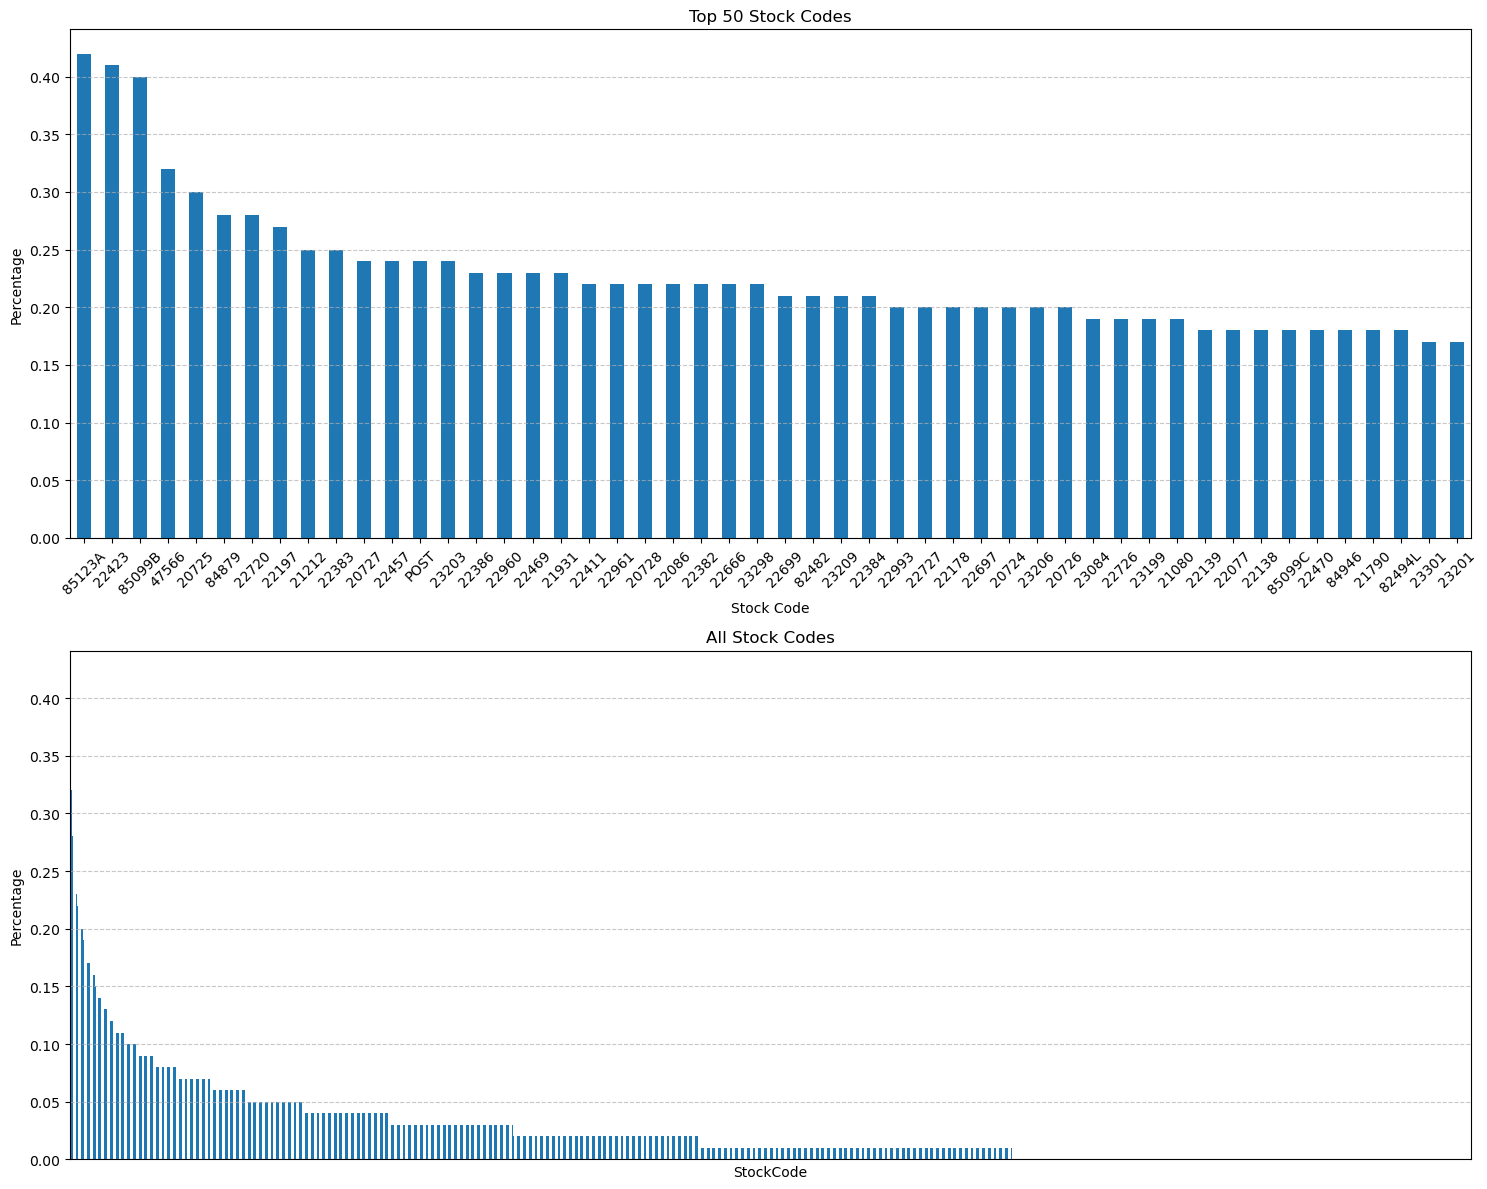

In [30]:
"""
Plotting the top 50 StockCodes with highest frequency, as well as all the StockCodes in one plot in order to understand the 
general distribution of product preferences.
"""
# Calculate the percentage for each stock code
stockcode_percentage = round(((df["StockCode"].value_counts() / len(df)) * 100), 2)

# Select and plot the top 50 StockCodes
top_50_stockcodes = stockcode_percentage.head(50)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
top_50_stockcodes.plot(kind="bar")
plt.title("Top 50 Stock Codes")
plt.xlabel("Stock Code")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot all StockCodes without x ticks
plt.subplot(2, 1, 2)
stockcode_percentage.plot(kind="bar")
plt.title("All Stock Codes")
plt.ylabel("Percentage")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([])

plt.tight_layout()
plt.show()

These two plots give insight that there is a clear difference between "popular" products and less "popular" products based on the purchase frequency. This information can help to cluster customers based on what sort of products they are most interested in.

In [31]:
"""
The first step in addressing the StockCode anomalies is understanding the frequency and different type of anomalies. This will be done
by taking a closer look into the number of numeric characters for each code.
"""
unique_sc = df["StockCode"].unique()
num_unique_sc = pd.Series(unique_sc).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Value counts of numeric character frequencies in unique stock codes:\n")
print(num_unique_sc)

Value counts of numeric character frequencies in unique stock codes:

5    3931
0      13
4       8
6       5
1       1
Name: count, dtype: int64


In [32]:
"""
As expected, the majority contain the standard format of 5 numbers (3931), the anomalie analysis will continue only for those who have 
0, 1, 4 or 6 numeric characters.
"""
# Define a function to count digits in a string
def count_digits(s):
    return sum(c.isdigit() for c in str(s))

# Filter the stock codes based on the number of digits
filtered_stock_codes = [code for code in unique_sc if count_digits(code) in [0, 1, 4, 6]]

filtered_stock_codes

['POST',
 'D',
 'C2',
 'DOT',
 'M',
 'BANK CHARGES',
 'S',
 'AMAZONFEE',
 'DCGS0076',
 'DCGS0003',
 'gift_0001_40',
 'DCGS0070',
 'm',
 'gift_0001_50',
 'gift_0001_30',
 'gift_0001_20',
 'DCGS0069',
 'DCGSSBOY',
 'DCGSSGIRL',
 'gift_0001_10',
 'PADS',
 'DCGS0004',
 'DCGS0073',
 'DCGS0068',
 'DCGS0067',
 'B',
 'CRUK']

In [33]:
"""
These StockCodes seem to represent transactions which do not concern the actual product. Codes like "AMAZONFEE", "BANK CHARGES" and "POST",
seem to instead represent other non-relevant characteristics of a transaction, such as postage fee or bank charges.

I will now check the proportion of rows with these anomalies in comparison to the full dataset.
"""
print("The percentage of rows whose StockCode are anomalies are", round(((len(df.loc[df["StockCode"].isin(filtered_stock_codes)]) / len(df)) * 100), 2), "%")

The percentage of rows whose StockCode are anomalies are 0.54 %


In [34]:
"""
Since the Codes present information which does not concern the actual product transaction and is assumed to not affect the customer's
purchasing behaviour and decision, and these rows present a very small proportion of the full dataset (0.54%); these rows will be removed
to avoid that these anomalies create noise in the clustering of customers and creation of a robust reccomendation system.
"""
df = df[~df["StockCode"].isin(filtered_stock_codes)]

In [35]:
"""
The next step is to understand those stock code anomalies which are composed by the standard format (5 numbers) and an additional
letter (e.g. 12345A). If the final letter does not distinguish a product from another it will be removed, however, if it does
identify different products then these stockcodes will be left untouched.
"""
df[df["StockCode"].str.contains(r"[A-Za-z]")]["StockCode"].value_counts()

StockCode
85123A    2246
85099B    2135
85099C     947
82494L     928
85099F     828
          ... 
84596g       1
90152C       1
84803A       1
84612B       1
47591b       1
Name: count, Length: 1046, dtype: int64

In [36]:
"""
Observing a few random exemplary cases to understand better the anomalie.
"""
print(df.loc[df["StockCode"].str.startswith("84029"), ["StockCode", "Description"]].value_counts(), "\n")
print(df.loc[df["StockCode"].str.startswith("85099"), ["StockCode", "Description"]].value_counts(), "\n")
print(df.loc[df["StockCode"].str.startswith("82494"), ["StockCode", "Description"]].value_counts(), "\n")
print(df.loc[df["StockCode"].str.startswith("47591"), ["StockCode", "Description"]].value_counts())

StockCode  Description                        
84029G     KNITTED UNION FLAG HOT WATER BOTTLE    463
84029E     RED WOOLLY HOTTIE WHITE HEART.         435
Name: count, dtype: int64 

StockCode  Description                   
85099B     JUMBO BAG RED RETROSPOT           2135
85099C     JUMBO  BAG BAROQUE BLACK WHITE     947
85099F     JUMBO BAG STRAWBERRY               828
85099f     JUMBO BAG STRAWBERRY                10
Name: count, dtype: int64 

StockCode  Description                
82494L     WOODEN FRAME ANTIQUE WHITE     926
82494l     WOODEN FRAME ANTIQUE WHITE      61
82494L     cracked                          1
           crushed ctn                      1
Name: count, dtype: int64 

StockCode  Description                    
47591D     PINK FAIRY CAKE CHILDRENS APRON    441
47591B     SCOTTIES CHILDRENS APRON            56
47591d     PINK FAIRY CAKE CHILDRENS APRON     56
47591B     ?                                    1
47591b     SCOTTIES CHILDRENS APRON             1
Nam

In [37]:
"""
From these exemplary cases many insights can be taken:

STOCKCODE INSIGHTS:
1. A different letter following the 5 numbers is to identify different products. Since this column acts as a unique identifier for products, it implies
that no action will be taken as the StockCode (although not compliant to the standard format) for this use case, still completes it's job as a 
unique identifier.

2. Some letters are in capital format whiles other in lower-case format. This anomalie will be addressed in order to ensure that the unique identifier
does not introduce avoidable noise to the data.
"""
df["StockCode"] = df["StockCode"].str.upper()

In [38]:
"""
DESCRIPTION INSIGHTS:
1. There are some Descriptions which contain values such as "cracked" and "crushed ctn". These descriptions seem like reasons to why a transaction has been
cancelled. They also are in lowercase format in comparison to the uppercase format which the products consistently 
seem to be in (this may be a standirdized format that hasn't been touched upon in the provided data dictionary). This will require further investigation.

2. There are some Descriptions which contain "?". This will have to be further investigated before understanding what action should be taken to address the anomalie.
"""
lc = df.loc[df["Description"].astype(str).str.islower(), "Description"].value_counts()

for value in lc.index:
    print(value)

check
damages
damaged
found
sold as set on dotcom
adjustment
thrown away
amazon
dotcom
damages?
had been put aside
wet damaged
smashed
test
wet pallet
missing
mailout
wet/rusty
reverse 21/5/10 adjustment
returned
crushed
stock check
counted
wrongly coded 20713
damages wax
printing smudges/thrown away
mixed up
taig adjust
?missing
incorrect stock entry.
sold as 1
rusty throw away
???missing
wet rusty
check?
?? missing
????damages????
historic computer difference?....se
website fixed
found box
????missing
for online retail orders
water damaged
rusty thrown away
allocate stock for dotcom orders ta
lost in space
temp adjustment
wet?
wet boxes
crushed ctn
lost??
add stock to allocate online orders
michel oops
wrongly marked carton 22804
wrongly marked 23343
dotcom sales
wrongly marked
wrongly coded 23343
?display?
re-adjustment
missing?
wet
mouldy
dotcom adjust
amazon adjust
can't find
crushed boxes
???lost
dotcomstock
wrongly coded-23343
sold with wrong barcode
20713 wrongly marked
mix up 

In [39]:
"""
It is apparent that all of these lowercase descriptions contain information which are not product descriptions. These descriptions present information which 
is unrelated to the actual product but instead to service details, doubts or errors within transactions.
"""
print("The amount of descriptions which contain information not relevant to the analysis are", round(((lc.shape[0] / len(df)) * 100), 2), "%")

The amount of descriptions which contain information not relevant to the analysis are 0.02 %


In [40]:
"""
Since these cases compone only 0.02% of the whole dataset, they will be deleted in order to avoid the introduction of noise to the models. They do not contain
relevant information for the scope of the project.
"""
df = df.loc[~df["Description"].astype(str).str.islower()]

In [41]:
"""
Next step is to check for lowercases at the character level.
"""
lowercase_descriptions = df["Description"].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions.astype(str) if any(char.islower() for char in desc)]

for desc in lowercase_descriptions:
    print(desc)

BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
BAG 125g SWIRLY MARBLES
BAG 250g SWIRLY MARBLES
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
Dr. Jam's Arouzer Stress Ball
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
Dad's Cab Electronic Meter
NUMBER TILE VINTAGE FONT No 
*Boombox Ipod Classic
Dotcom sales
*USB Office Mirror Ball
POLYESTER FILLER PAD 30CMx30CM
Found
Given away
Dotcom
Adjustment
Dotcom set
Amazon sold sets
Thrown away.
Dotcom sold in 6's
Damaged
mystery! Only ever imported 1800
Display
Missing
damages/credits from ASOS.
POLYESTER FILLER PAD 60x40cm
Not rcvd in 10/11/2010 delivery
Thrown away-rusty
FLOWERS HANDBAG blue and orange
incorrectly credited C550456 see 47
Next Day Carriage
Water damaged
Printing smudges/thrown away
Show Samples
THE KING GIFT BAG 25x24x12cm
Damages/samples
Dotcomgiftshop Gift Vouche

In [42]:
"""
Those descriptions which do not refer to a product name will be deleted as they are not important to the scope of the project at hand. Looking at
the descriptions highlights the need for FarTrend's staff to be trained to standirdize their descriptions (e.g. "OOPS ! adjustment", 
"Found in w/hse", "Dagamed")
"""
unimportant_descriptions = ["Found", "Given away", "Dotcom sales", "Dotcom", "Adjustment", "Dotcom set", "Amazon sold sets", "Thrown away.", "Dotcom sold in 6's", "Damaged", "Display", "Missing", "damages/credits from ASOS.", "Not rcvd in 10/11/2010 delivery", "Thrown away-rusty", "incorrectly credited C550456 see 47", "Next Day Carriage", "Water damaged", "Printing smudges/thrown away", "Show Samples", "Damages/samples", "Sold as 1 on dotcom", "Crushed", "Amazon", "OOPS ! adjustment", "Found in w/hse", "Dagamed", "Incorrect stock entry.", "Wet pallet-thrown away", "Had been put aside.", "Sale error", "High Resolution Image", "Amazon Adjustment", "Breakages", "Marked as 23343", "Found by jackie", "Damages", "Unsaleable, destroyed.", "Wrongly mrked had 85123a in box", "John Lewis"]

df = df.loc[~df["Description"].isin(unimportant_descriptions)]

In [43]:
df["Description"] = df["Description"].str.upper()

In [44]:
"""
Deleting all rows that contain "?" in the description as does not give any information relevant to the product.
"""
df = df.loc[~(df["Description"] == "?")]

##### Inspecting Unit Price 

In [45]:
"""
Looking at basic statistics of UnitPrice to understand better the distribution of the data and presence of potential outliers.
"""
print(df["UnitPrice"].describe())

count    526212.000000
mean          3.298462
std           4.524350
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max         649.500000
Name: UnitPrice, dtype: float64


In [46]:
"""
It can be observed in the dataframes printed above that there is sometimes a UnitPrice of 0, which could be because of the cancelled transaction. 
This will now be further investigated before potential action is taken.
"""
print("The amount of rows which have a unit price equal to zero is", len(df.loc[df["UnitPrice"] == 0]))
df.loc[df["UnitPrice"] == 0].head(10)

The amount of rows which have a unit price equal to zero is 424


InvoiceNo StockCode                       Description  \
9302     537197     22841      ROUND CAKE TIN VINTAGE GREEN   
14335    537534     85064      CREAM SWEETHEART LETTER RACK   
14336    537534     84832  ZINC WILLIE WINKIE  CANDLE STICK   
14337    537534     84692       BOX OF 24 COCKTAIL PARASOLS   
14338    537534     48184             DOORMAT ENGLISH ROSE    
14339    537534     48111             DOORMAT 3 SMILEY CATS   
14340    537534     22697   GREEN REGENCY TEACUP AND SAUCER   
14341    537534     22682     FRENCH BLUE METAL DOOR SIGN 7   
14342    537534     22680     FRENCH BLUE METAL DOOR SIGN 5   
14343    537534     22681     FRENCH BLUE METAL DOOR SIGN 6   

              InvoiceDate  UnitPrice CustomerID         Country  \
9302  2010-12-05 14:02:00        0.0    12647.0         Germany   
14335 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14336 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14337 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14338 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14339 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14340 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14341 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14342 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   
14343 2010-12-07 11:48:00        0.0    18386.0  United Kingdom   

       TotalQuantity  TransactionStatus  
9302               1                  1  
14335              1                  1  
14336              1                  1  
14337              2                  1  
14338              3                  1  
14339              1                  1  
14340              1                  1  
14341              1                  1  
14342              1                  1  
14343              2                  1

In [47]:
"""
Checking if there are any negative Prices, which could present possible anomalies.
"""
len(df.loc[df["UnitPrice"] < 0])

0

In [48]:
"""
Based on the table above, there seems to be no correlation between a UnitPrice of 0 and e.g. an order being cancelled. Therefore, it will be
assumed that UnitPrice = 0 is due to a system error and since it is the case in a small proportion of the whole dataset (424), these rows 
will be removed to avoid the introduction of noise into the data analysis.
"""
df = df.loc[df["UnitPrice"] > 0]

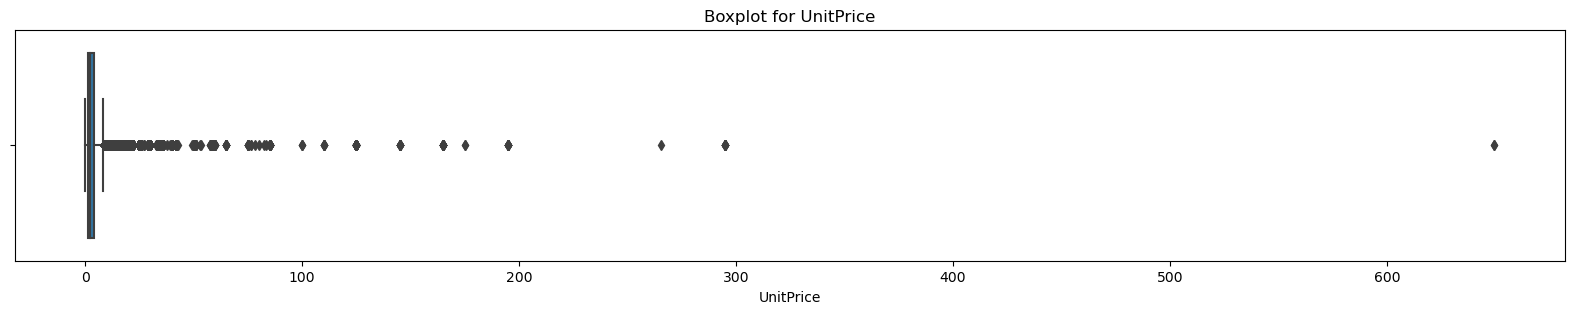

In [49]:
"""
As pointed out before, the big difference between the 75th quartile (4.13) and the maximum value (649.50) implies the presence of outliers.
Plotting a boxplot of the UnitPrice will allow to better understand the data.
"""
plt.figure(figsize=(20, 3))
sns.boxplot(x=df["UnitPrice"])
plt.title("Boxplot for UnitPrice")
plt.xlabel("UnitPrice")
plt.show()

In [50]:
"""
Further investigation is necessary to understand whether these high prices represent anomalies or if they are simply luxurious products
sold by FarTrend.
"""
df.loc[df["UnitPrice"]>=100]["StockCode"].value_counts()

StockCode
22655    44
22827    28
22656    25
22826    13
22823    13
22828     7
22502     2
22833     1
Name: count, dtype: int64

In [51]:
"""
Although it is logical that more expensive products are not bought as frequent as cheaper products, random examples will be further investigated
to ensure that these outliers simply represent luxurious/more expensive products.
"""
print(df.loc[df["StockCode"] == "22823", ["Description", "InvoiceDate", "UnitPrice"]], "\n")
print(df.loc[df["StockCode"] == "22828", ["Description", "InvoiceDate", "UnitPrice"]])

                          Description         InvoiceDate  UnitPrice
39739   CHEST NATURAL WOOD 20 DRAWERS 2010-12-21 10:26:00      125.0
61549   CHEST NATURAL WOOD 20 DRAWERS 2011-01-18 08:44:00      110.0
66285   CHEST NATURAL WOOD 20 DRAWERS 2011-01-21 13:07:00      110.0
100581  CHEST NATURAL WOOD 20 DRAWERS 2011-02-24 09:32:00      125.0
126150  CHEST NATURAL WOOD 20 DRAWERS 2011-03-20 13:38:00      125.0
149887  CHEST NATURAL WOOD 20 DRAWERS 2011-04-08 09:25:00      125.0
172793  CHEST NATURAL WOOD 20 DRAWERS 2011-05-03 10:42:00      110.0
245688  CHEST NATURAL WOOD 20 DRAWERS 2011-06-30 17:40:00      125.0
304851  CHEST NATURAL WOOD 20 DRAWERS 2011-08-18 08:49:00      125.0
320596  CHEST NATURAL WOOD 20 DRAWERS 2011-08-31 17:12:00      110.0
326983  CHEST NATURAL WOOD 20 DRAWERS 2011-09-05 15:26:00      125.0
338448  CHEST NATURAL WOOD 20 DRAWERS 2011-09-13 11:47:00      110.0
468546  CHEST NATURAL WOOD 20 DRAWERS 2011-11-15 12:09:00      110.0 

                         Descrip

Looking at these example, it is apparent that the outliers represent simply more expensive products. It is also interesting to notice that there
are regular changes in the price of the product over time. It is assumed this is due to FarTrend having an algorithm which adjusts prices based
on e.g. competitors prices, demand and so on. Therefore, nothing will be done to the outliers.

C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


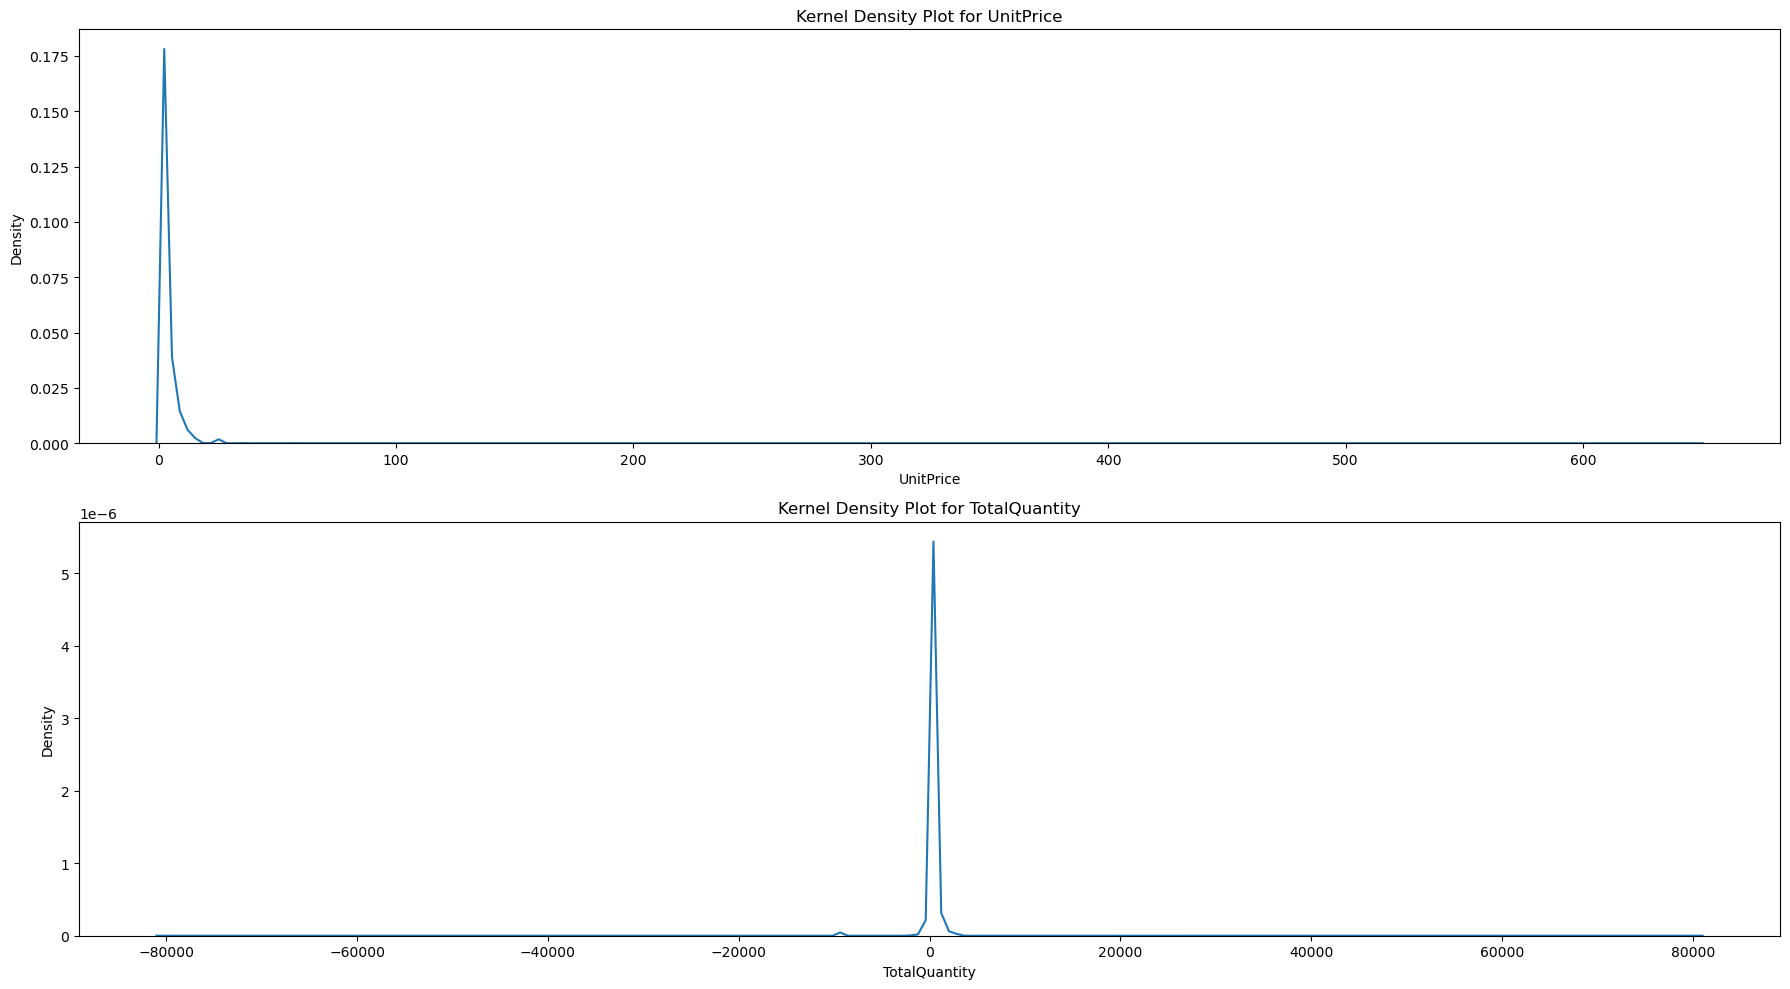

In [52]:
"""
Plotting a series of kernel density plots so each attribute's distribution can be visualized, allowing for an intuitive comparison across different aspects of customer data.
The use of kdeplot for each feature provides insights into the distribution shapes, revealing patterns such as skewness or bimodality.

Since UnitPrice and TotalQuantity are continuous variables, kde plots are appropriate to visualize the data.
"""
# Set up the figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Kernel density plot for UnitPrice
sns.kdeplot(data=df["UnitPrice"], ax=axes[0])
axes[0].set_title("Kernel Density Plot for UnitPrice")

# Kernel density plot for TotalQuantity
sns.kdeplot(data=df["TotalQuantity"], ax=axes[1])
axes[1].set_title("Kernel Density Plot for TotalQuantity")

# Show the plot
plt.tight_layout()
plt.show()

Both plots show a peak around zero with a right skew for UnitPrice and a left and right skey for TotalQuantity (which reflects also the cancelled orders). The skewness in both kde plots represent the outlier values discussed beforehand.

##### Timeliness: Anomalies or Outliers

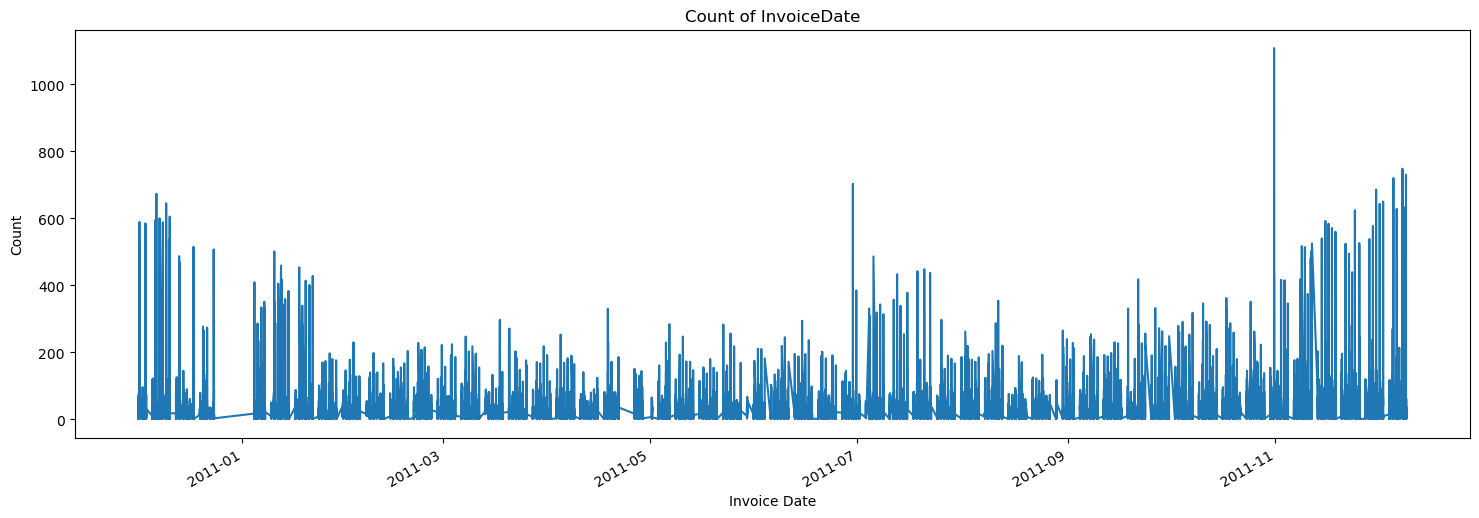

In [53]:
"""
Plotting Invoice Date to see the general distribution over time and if there are any anomalies
"""
plt.figure(figsize=(18, 6))

df["InvoiceDate"].value_counts().sort_index().plot(kind="line")

plt.xlabel("Invoice Date")
plt.ylabel("Count")
plt.title("Count of InvoiceDate")
plt.show()

The empty spaces in this time series plot likely represent periods with no invoice activity for the e-commerce company. However, this anomalie could be due to a variety of reasons:
- Data Collection Issues: There might have been problems with data logging during those times, leading to missing entries.
- Operational Breaks: FarTrend could have had non-operating days due to weekends, holidays, or scheduled maintenance when no transactions were processed.
- System Downtime: Technical issues such as server downtimes or outages could have prevented transaction processing.

Since no extra information has been provided on this regard, the time intervals seem mostly to be systematic (9 empty spaces on average per month), and the time of transactions is not the most important aspect of this project, it will be assumed that it is not a system data collection error but rather due to Operational Breaks. Therefore, nothing will be done to treat this data.

##### Plotting Relationships between variables

Before continuing to the Feature Engineering section which will create statistics based on the specific customer, a brief analysis on general company
statistics will be done in order to understand better the business context, including:
- AVG charge per customer order
- AVG amount of products purchased per transaction
- Top 30 most sold products
- Monthly/Quartely revenue trends
- Distribution of Customers by the top 10 Countries

In [54]:
# Calculate average charge per customer order
df["TotSpent"] = df["UnitPrice"] * df["TotalQuantity"]

avg_charge_per_order = df.groupby("InvoiceNo")["TotSpent"].sum().mean()
print("Average charge per customer order is", round(avg_charge_per_order, 2), "pounds")

Average charge per customer order is 422.09 pounds


In [55]:
# Calculate average amount of products purchased per transaction
avg_products_per_transaction = df.groupby("InvoiceNo")["TotalQuantity"].sum().mean()
print("Average amount of products purchased per transaction is", round(avg_products_per_transaction, 2))

Average amount of products purchased per transaction is 228.72


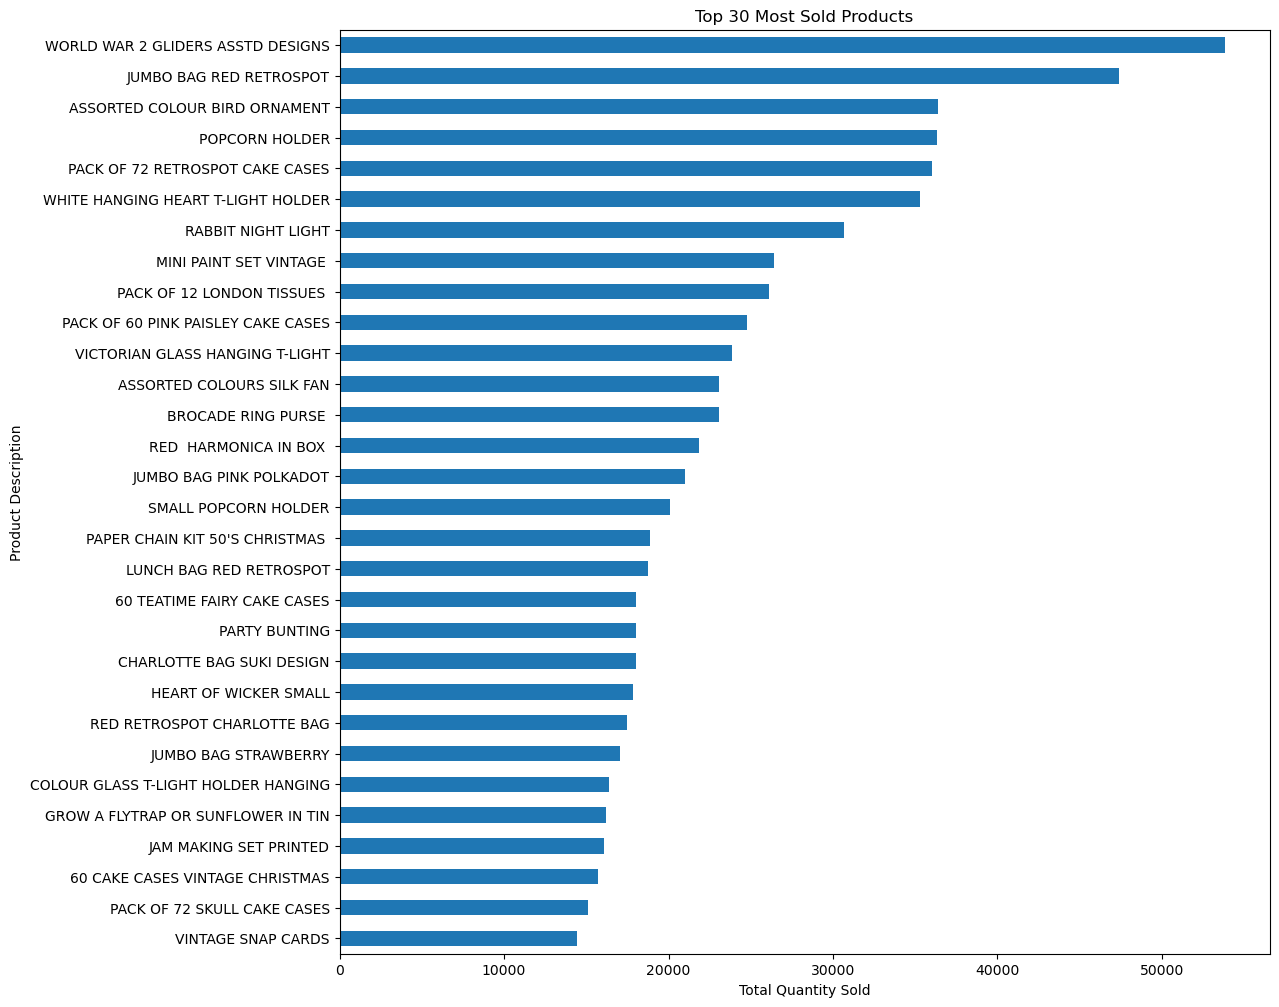

In [56]:
# Plot top 30 most sold products
top_30_products = df.groupby("Description")["TotalQuantity"].sum().nlargest(30)

plt.figure(figsize=(12, 12))  
top_30_products.plot(kind="barh")  
plt.title("Top 30 Most Sold Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")  
plt.gca().invert_yaxis()
plt.show()

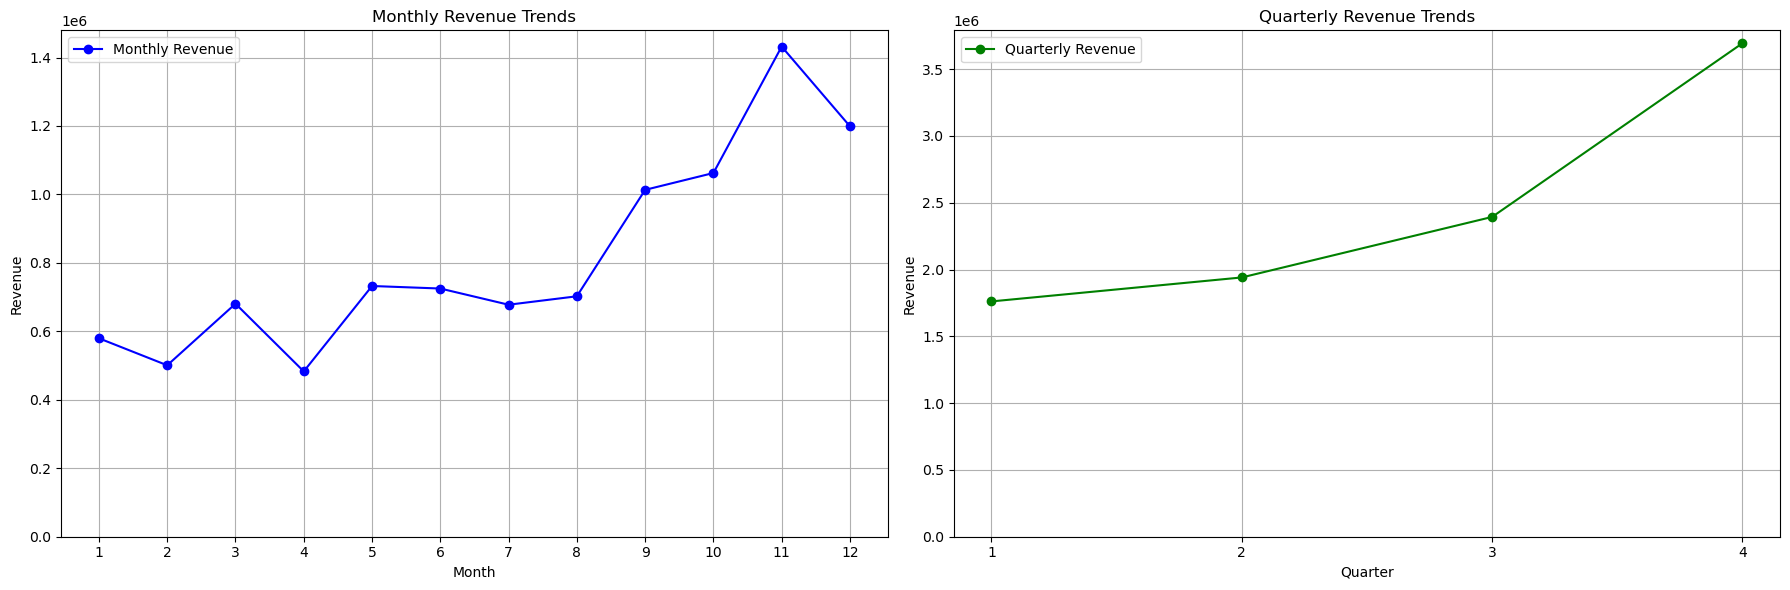

In [57]:
# Extract month and quarter from InvoiceDate
df["Month"] = df["InvoiceDate"].dt.month
df["Quarter"] = df["InvoiceDate"].dt.quarter

monthly_revenue = df.groupby("Month")["TotSpent"].sum()
quarterly_revenue = df.groupby("Quarter")["TotSpent"].sum()

# Plot monthly revenue trends
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
monthly_revenue.plot(kind="line", marker="o", color="b", label="Monthly Revenue")
plt.title("Monthly Revenue Trends")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.ylim(0)  

# Plot quarterly revenue trends
plt.subplot(1, 2, 2)
quarterly_revenue.plot(kind="line", marker="o", color="g", label="Quarterly Revenue")
plt.title("Quarterly Revenue Trends")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.xticks(range(1, 5))
plt.grid(True)
plt.legend()
plt.ylim(0)  

plt.tight_layout()
plt.show()

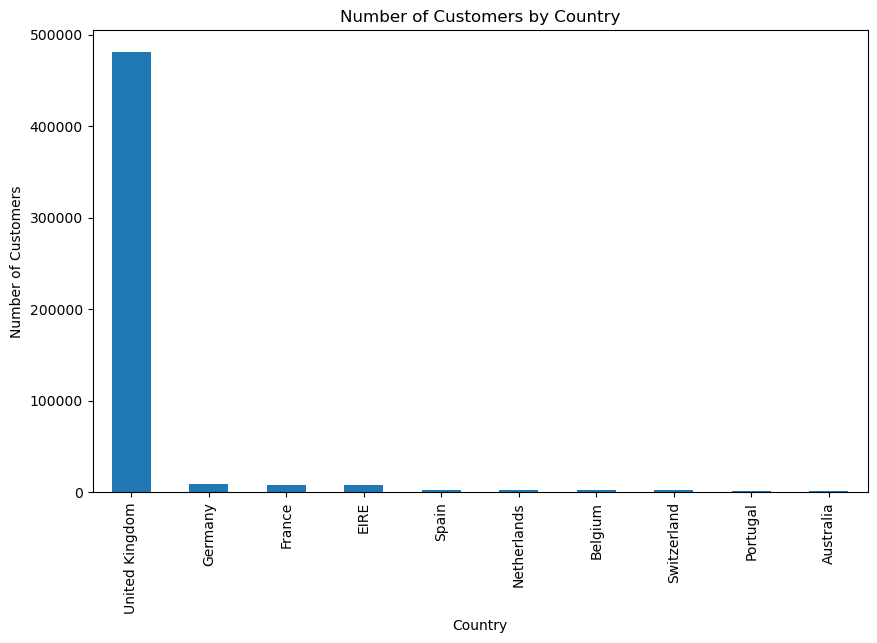

In [58]:
# Plot the number of customers for the top 10 countries
top_10_countries = df["Country"].value_counts().nlargest(10)

top_10_countries.plot(kind="bar", figsize=(10, 6))

plt.title("Number of Customers by Country")
plt.xlabel("Country")
plt.ylabel("Number of Customers")
plt.show()

In [59]:
df.head()

InvoiceNo StockCode                          Description  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1    536365     71053                  WHITE METAL LANTERN   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

          InvoiceDate  UnitPrice CustomerID         Country  TotalQuantity  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom              6   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom              6   
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom              8   
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom              6   
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom              6   

   TransactionStatus  TotSpent  Month  Quarter  
0                  1     15.30     12        4  
1                  1     20.34     12        4  
2                  1     22.00     12        4  
3                  1     20.34     12        4  
4                  1     20.34     12        4

##### Feature Engineering

In this section, features will be created based on the current df and will be stored in a new df which has a designated row for each customer id. This will allow to focus on customer-based features. This will aid in extracting important information to effectively segment customers.

In [60]:
"""
DAYS SINCE CUSTOMER'S LAST ORDER

This variable will be based on the latest Invoice Date of the customer. Adding this feature to the dataset will allow to asses whether the customer has recently
been active or if they haven't been in a while. By assessing the customer's engagement, it allows to personalise marketing strategies to make the customer
re-engage with the website.
"""
today = df["InvoiceDate"].max()

df["InvoiceDay"] = df["InvoiceDate"].dt.date

dfc = df.groupby("CustomerID")["InvoiceDay"].max().reset_index()

dfc["InvoiceDay"] = pd.to_datetime(dfc["InvoiceDay"])

dfc["LastOrderDay"] = (today - dfc["InvoiceDay"]).dt.days

dfc.drop(["InvoiceDay"], axis = 1, inplace = True)

In [61]:
"""
TOTAL AMOUNT OF TRANSACTIONS & TOTAL AMOUNT OF PRODUCTS BOUGHT

These Frequency statistics concerning the amount of transactions and products bought show important insights into the customers purchasing patterns:
- The amount of transactions in total they have done
- The total amount of products they have purchased
"""
transaction_product = df.groupby("CustomerID").agg(TotalTransactions = ("InvoiceNo", "nunique"), TotalProductsPurchased = ("TotalQuantity", "sum")).reset_index()

dfc = pd.merge(dfc, transaction_product, on = "CustomerID")

In [62]:
"""
TOTAL SPENT & AVG SPENT PER TRANSACTION

These two statistics concern the monetary value of transactions. They shed light into the client's spending habits and can aid in segmenting customers
based on being high, medium or low spenders.
"""
totalspent = df.groupby("CustomerID")["TotSpent"].sum().reset_index()

dfc = pd.merge(dfc, totalspent, on = "CustomerID")

dfc["AvgSpentTransaction"] = dfc["TotSpent"] / dfc["TotalTransactions"]

In [63]:
"""
PRODUCT DIVERSITY

Now a step more in depth will be taken, and it will be analysed how diverse the customer is in buying products. Does the customer always buy the same
product? Is the customer always buying something new? This feature will give insights that the marketing team will be able to use to market either 
1. similar products to the customer or 2. incentivize the customer to buy again the same products.
"""
ProductDiversity = df.groupby("CustomerID")["StockCode"].nunique().reset_index()
ProductDiversity = ProductDiversity.rename(columns={"StockCode": "ProductDiversity"})

dfc = pd.merge(dfc, ProductDiversity, on = "CustomerID")

In [64]:
dfc.head()

CustomerID  LastOrderDay  TotalTransactions  TotalProductsPurchased  \
0    12346.0           325                  2                       0   
1    12347.0             2                  7                    2458   
2    12348.0            75                  4                    2332   
3    12349.0            18                  1                     630   
4    12350.0           310                  1                     196   

   TotSpent  AvgSpentTransaction  ProductDiversity  
0      0.00             0.000000                 1  
1   4310.00           615.714286               103  
2   1499.64           374.910000                21  
3   1457.55          1457.550000                72  
4    294.40           294.400000                16

In [65]:
"""
AMOUNT OF DAYS IN BETWEEN ORDERS

This is an important feature to include in the analysis as it gives insight into the time interval of the customer's purchases. Whether someone is purchasing
on a daily, weekly or monthly basis can influence the frequency of advertisements sent to the customer.

It is important to consider those cases with just one transaction. For these customers, the lack of repeat transactions means we can't calculate the average 
days between purchases directly. Therefore, two actions will be taken for these cases:
1. A placeholder value will be added
        Since the data provided covers only one year of transactions, using a high value could inadvertently classify these new or one-time customers as low
        priority for re-engagement marketing efforts. Therefore, the placeholder value will be calculated based on the median interval from customers with
        multiple transactions.
        
2. A binary variable will indicate those customers who have only done a single purchase
        This segmentation is crucial for crafting targeted marketing strategies aimed at converting one-time buyers into repeat customers.
"""
df_sort = df.sort_values(by=["CustomerID", "InvoiceDate"])

df_sort["AvgDaysBetweenPurchases"] = df_sort.groupby("CustomerID")["InvoiceDate"].diff().dt.days

MedianDays = df_sort["AvgDaysBetweenPurchases"].median()

df_sort["AvgDaysBetweenPurchases"].fillna(MedianDays, inplace=True)

AvgDays = df_sort.groupby("CustomerID")["AvgDaysBetweenPurchases"].mean().reset_index()

dfc = pd.merge(dfc, AvgDays, on="CustomerID", how="left")

dfc["SinglePurchase"] = np.where(dfc["AvgDaysBetweenPurchases"] == MedianDays, 1, 0)

In [66]:
"""
CANCELLATION

Understanding the amount of times a customer has cancelled orders in the past and the ratio of cancellations is an essential piece of information in
regard to understanding what sort of marketing and retention strategies can help to persuade the customer to go through with the order. 
"""
CancellationCounts = df[df["TransactionStatus"] == 0].groupby(["CustomerID", "InvoiceNo"]).size().reset_index(name="CancellationCount")

CancellationCountsCustomer = CancellationCounts.groupby("CustomerID")["CancellationCount"].sum().reset_index()

dfc = pd.merge(dfc, CancellationCountsCustomer, on="CustomerID", how="left")

dfc["CancellationCount"].fillna(0, inplace=True)

dfc["CancellationFrequency"] = dfc["CancellationCount"] / dfc["TotalTransactions"]

In [67]:
"""
GEOGRAPHY - UK or not?

Looking at the geographical data available, and having seen beforehand in the EDA that the majority of customers come from the UK, differentiating
between UK customer and non-UK customers could lead to interesting insights of the different customer behaviours. Perhaps there are different products 
these two groups of customers prefer to buy, or maybe there is a difference in the customer value (based on their spending and frequency considering 
that shipping costs present a bigger financial burden to non-UK customers).

A dummy variable will be created where 1 represents a customer from the UK and 0 a customer outside of the UK. Beforehand, it will be checked if
customers tend to purchase from various countries or if they consistently purchase from the same.
"""
df.groupby("CustomerID")["Country"].nunique().sort_values(ascending = False).head(5)

CustomerID
12431.0    2
12429.0    2
12457.0    2
12417.0    2
12455.0    2
Name: Country, dtype: int64

In [68]:
"""
Since there are customers which purchase from more than one country, that country which has the highest amount of transactions will be the 
country taken into consideration for this dummy variable.
"""
CountryCustomer = df.groupby("CustomerID")["Country"].size().reset_index()

max_country = df.groupby("CustomerID")["Country"].agg(lambda x: x.value_counts().idxmax()).reset_index()
max_country.columns = ["CustomerID", "MaxCountry"]

CountryCustomer = pd.merge(CountryCustomer, max_country, on="CustomerID")

CountryCustomer["UKCustomer"] = np.where(CountryCustomer["MaxCountry"] == "United Kingdom", 1, 0)

CountryCustomer.drop(["Country", "MaxCountry"], axis=1, inplace=True)

dfc = pd.merge(dfc, CountryCustomer, on="CustomerID")

In [69]:
dfc["CustomerID"] = dfc["CustomerID"].astype(str)

In [70]:
dfc.head()

CustomerID  LastOrderDay  TotalTransactions  TotalProductsPurchased  \
0    12346.0           325                  2                       0   
1    12347.0             2                  7                    2458   
2    12348.0            75                  4                    2332   
3    12349.0            18                  1                     630   
4    12350.0           310                  1                     196   

   TotSpent  AvgSpentTransaction  ProductDiversity  AvgDaysBetweenPurchases  \
0      0.00             0.000000                 1                 0.000000   
1   4310.00           615.714286               103                 1.989011   
2   1499.64           374.910000                21                12.260870   
3   1457.55          1457.550000                72                 0.000000   
4    294.40           294.400000                16                 0.000000   

   SinglePurchase  CancellationCount  CancellationFrequency  UKCustomer  
0               1                1.0                    0.5           1  
1               0                0.0                    0.0           0  
2               0                0.0                    0.0           0  
3               1                0.0                    0.0           0  
4               1                0.0                    0.0           0

##### New Variable Distributions

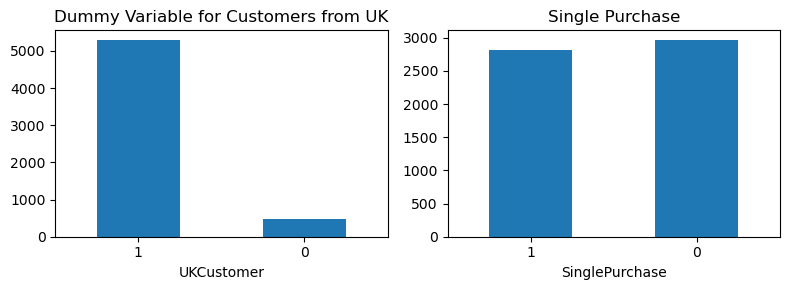

Where (1) implies YES and (0) implies NO


In [71]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot UKCustomer column
dfc["UKCustomer"].value_counts().sort_index(ascending=False).plot(kind="bar", rot=0, ax=axes[0])
axes[0].set_title("Dummy Variable for Customers from UK")

# Plot Single Purchase column
dfc["SinglePurchase"].value_counts().sort_index(ascending=False).plot(kind="bar", rot=0, ax=axes[1])
axes[1].set_title("Single Purchase")

plt.tight_layout()
plt.show()

print("Where (1) implies YES and (0) implies NO")

- The binary variable shows that the big majority of customers are from the UK.

- The binary variable shows that the amount of customers who purchased once or multiple times is almost equal.

C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

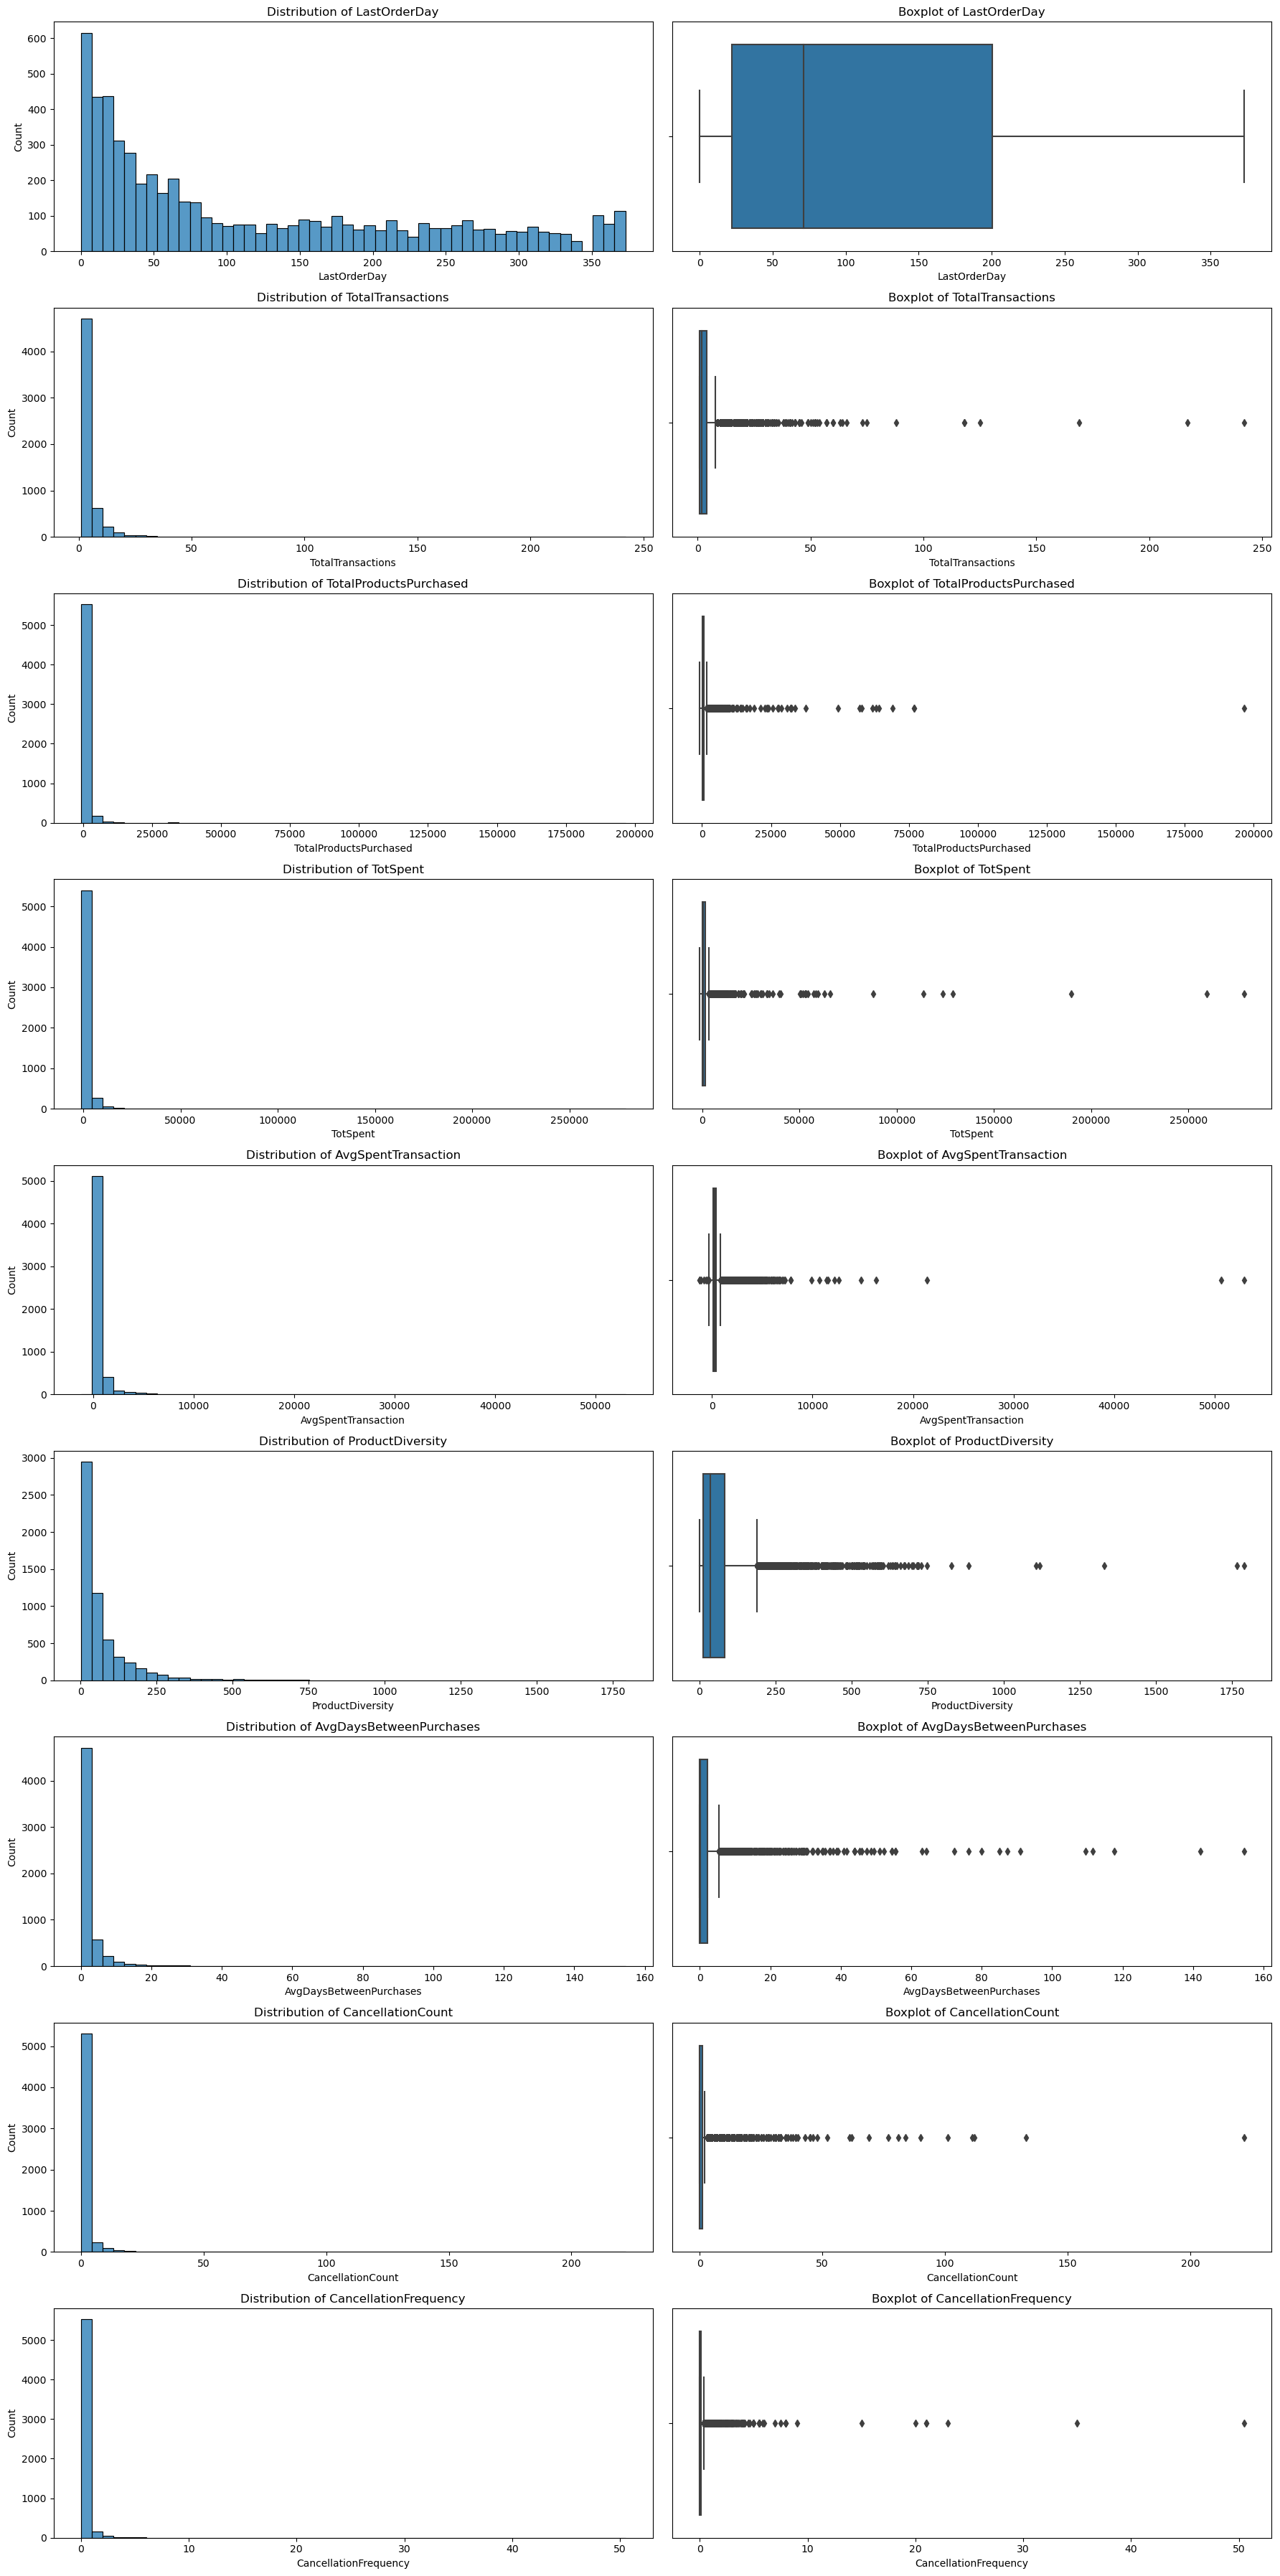

In [72]:
"""
Plotting all the new features on histograms and boxplots to see the distribution and potential anomalies.
"""
plot_columns = [col for col in dfc.columns if col not in ["CustomerID", "SinglePurchase", "UKCustomer"]]

# Calculate the number of rows needed for the subplots (one row for each feature)
num_columns = len(plot_columns)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=num_columns, ncols=2, figsize=(18, 4 * num_columns))

# Iterate through the list of columns to plot and their respective index
for i, column in enumerate(plot_columns):
    # Histogram on the left
    sns.histplot(dfc[column], ax=axes[i, 0], bins=50, edgecolor="k")
    axes[i, 0].set_title(f"Distribution of {column}")
    
    # Boxplot on the right
    sns.boxplot(x=dfc[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

In analyzing our dataset through histograms and boxplots, outliers have been identified. However, as the project's objectives is to segment customers and develop a tailored recommendation system these outliers can be important as they may represent significant customer segments, such as those making **occasional high-value purchases or having unique buying preferences**. Nonetheless, due to the use of models like K-means Clustering where **outliers can significtanly affect and distort the centroids of clusters**, Isolation Forest will be applied. This approach allows us to focus on capturing typical customer behavior patterns and identifying meaningful segments within our customer base. By removing outliers, we aim to ensure that the resulting clusters represent the majority of customers and are not skewed by extreme values.

However, for recommendation systems, outliers will be retained and included in our analysis. This decision is based on the understanding that outliers can provide valuable insights into unique customer preferences and behaviors. By incorporating outliers into our recommendation algorithms, we can enhance the personalization of product offerings and ensure that our recommendations are diverse and inclusive of all customer profiles.

##### Addressing Outliers - Isolation Forest

Unlike traditional methods that focus on profiling normal data points, Isolation Forest builds a set of random decision trees. It isolates anomalies by observing how quickly they can be separated from the majority of data points, which provides resilience to overfitting. Anomalies typically require fewer partitions to isolate, making them stand out as shorter paths in the trees. This approach is computationally efficient and particularly effective for large datasets with high-dimensional features. Isolation Forest offers scalability and versatility, excelling with high-dimensional data and adapting well to large datasets, thus fitting real-world scenarios seamlessly.

In [73]:
"""
After experimenting with various contamination levels, a level of 7.5% was chosen as it strikes a balance between removing outliers effectively
and preserving the integrity of the dataset (to avoid overfitting), ensuring that essential customer behaviors are retained.
"""
isolation_forest = IsolationForest(contamination=0.075, random_state=42)

isolation_forest.fit(dfc)
outliers = isolation_forest.predict(dfc)

# Convert predictions to 1 for outliers and 0 for non-outliers
outliers = [1 if pred == -1 else 0 for pred in outliers]

dfc["IsOutlier"] = outliers

C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

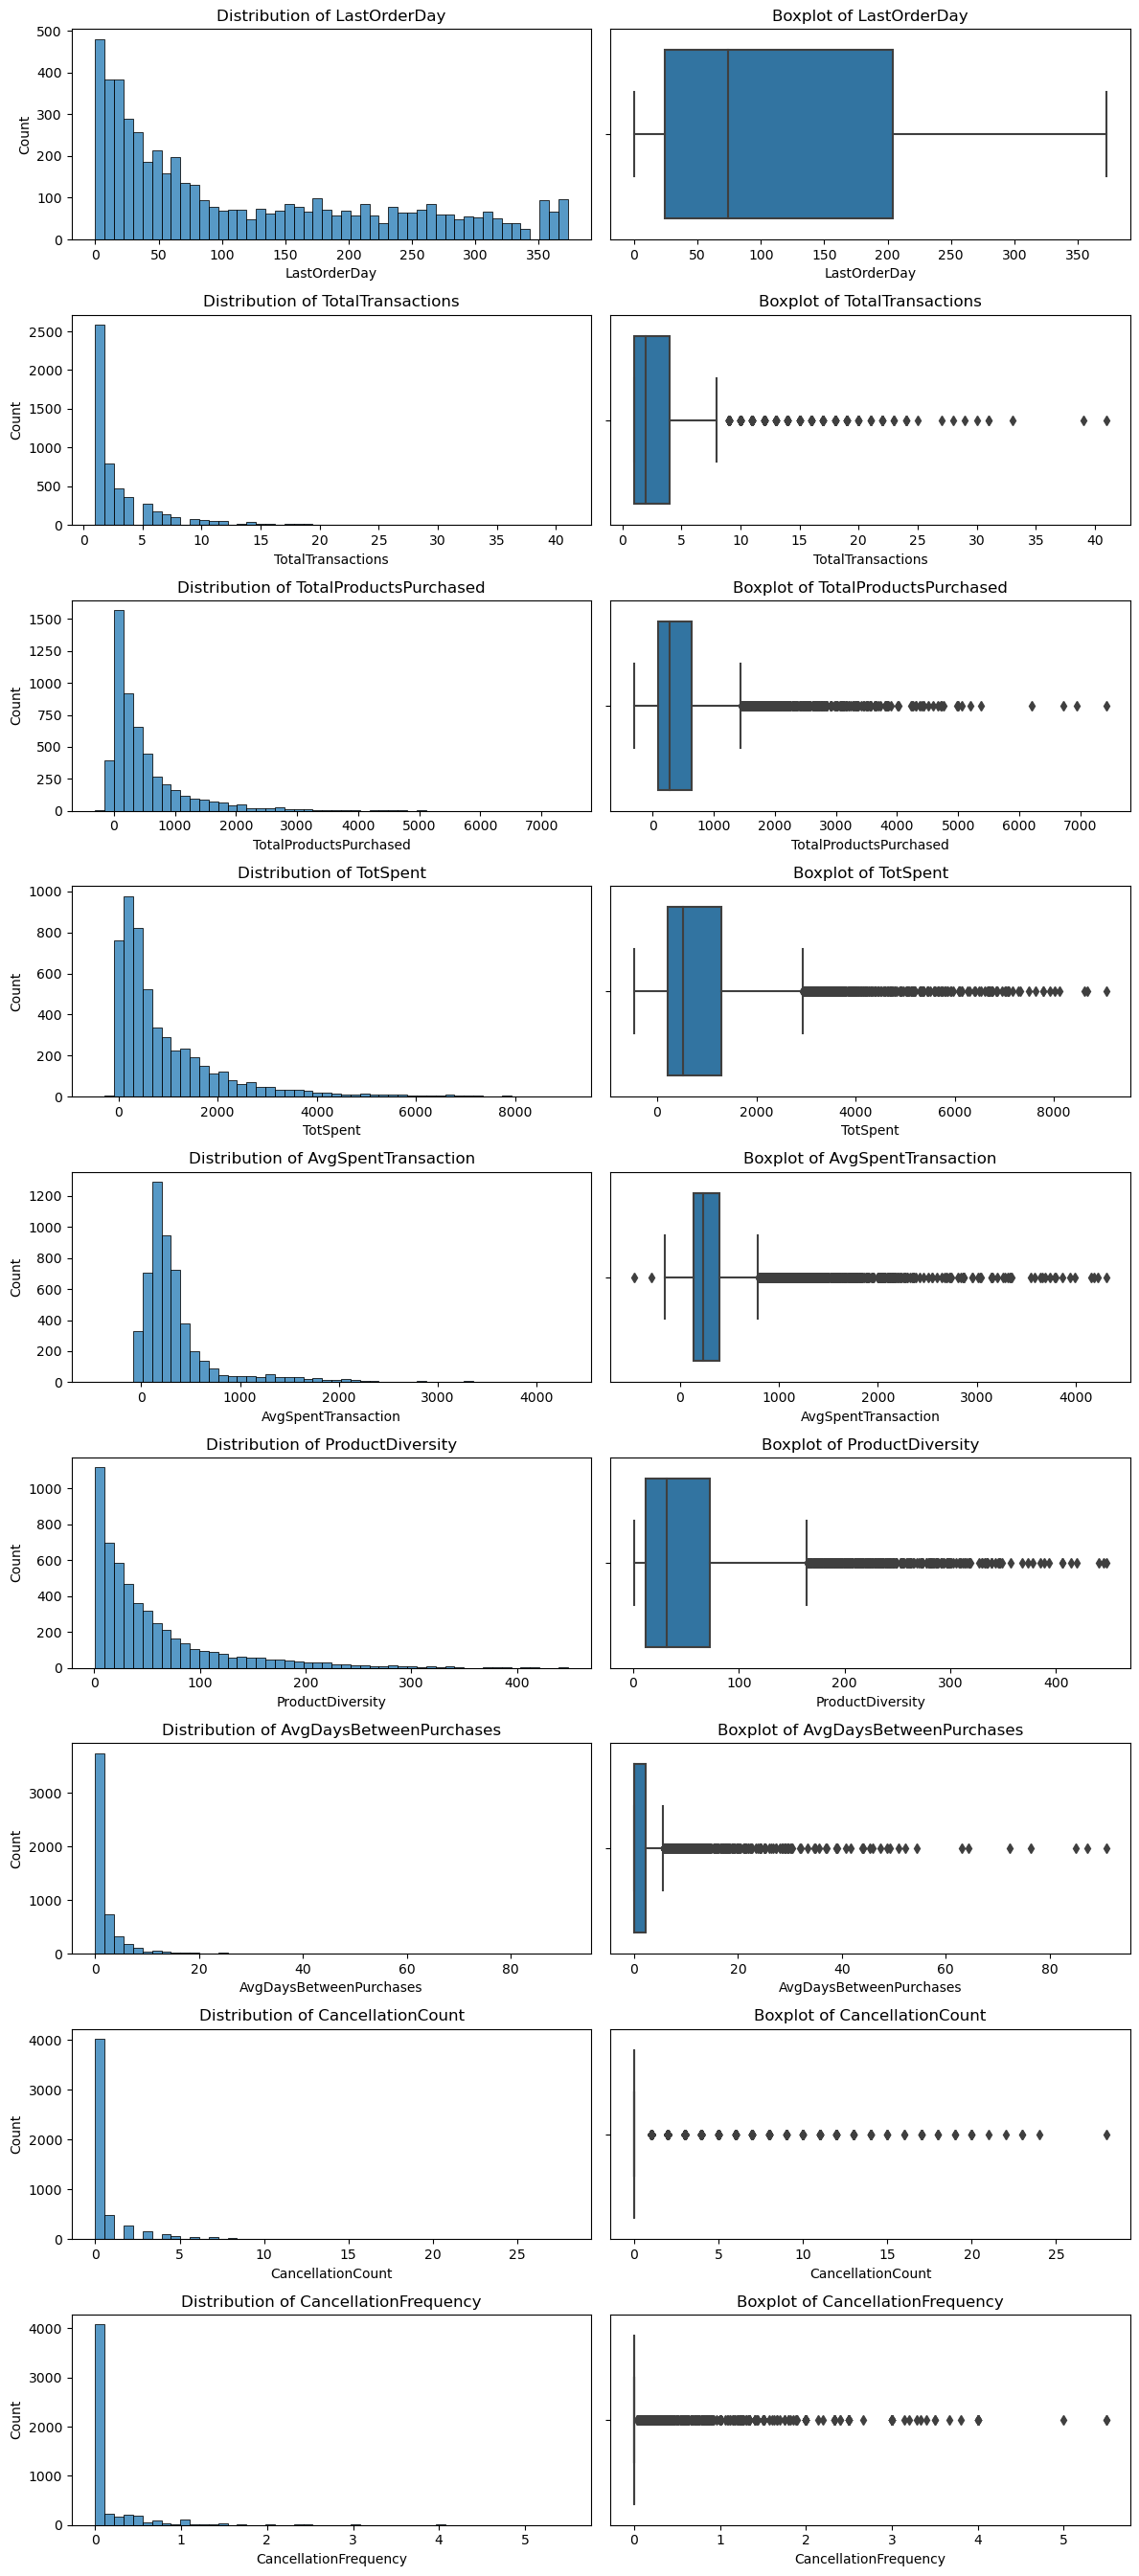

In [74]:
"""
Plotting the same plot as before but filtering to include only those rows which have not been detected as outliers. This allows to understand
how the distribution changes by using Isolation Forest to detect anomalies.
"""
dfc_no_outliers = dfc[dfc["IsOutlier"] == 0]

num_columns = len(plot_columns)

fig, axes = plt.subplots(nrows=num_columns, ncols=2, figsize=(12, 3 * num_columns))

for i, column in enumerate(plot_columns):
    # Histogram on the left
    sns.histplot(dfc_no_outliers[column], ax=axes[i, 0], bins=50, edgecolor="k")
    axes[i, 0].set_title(f"Distribution of {column}")
    
    # Boxplot on the right
    sns.boxplot(x=dfc_no_outliers[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

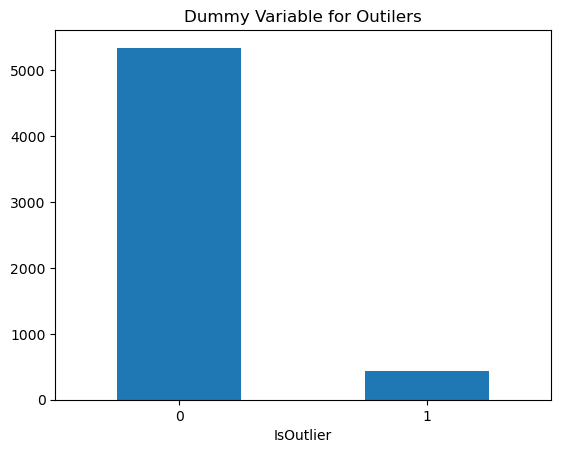

Where (1) implies YES and (0) implies NO
The detected proportion of outliers in comparison to the whole dataset is 7.5 %. This reflects the choice in contamination level.


In [75]:
dfc["IsOutlier"].value_counts().plot(kind = "bar", rot = 0)
plt.title("Dummy Variable for Outilers")
plt.show()

print("Where (1) implies YES and (0) implies NO")

print("The detected proportion of outliers in comparison to the whole dataset is", round((len(dfc.loc[dfc["IsOutlier"] == 1]) / len(dfc)) * 100, 2), "%. This reflects the choice in contamination level.")

##### Correlation of Variables

A heatmap of the correlation amoung variables will be plotted. In order to justify the deletion of 7.5% of the dataset due to outliers, two correlation plots will be compared. The first including the outlier rows and the second excluding. If there is stronger correlations found in the df excluding outliers, the removal of 7.5% of the dataset is justified due to the stronger correlations which will allow the unsupervised model to better identify and segment customers.

It is important to asses this as outliers can either inflate or deflate the perceived strength of the relationship between variables, and this will effect the ability for the model to effectively capture different customer segments.

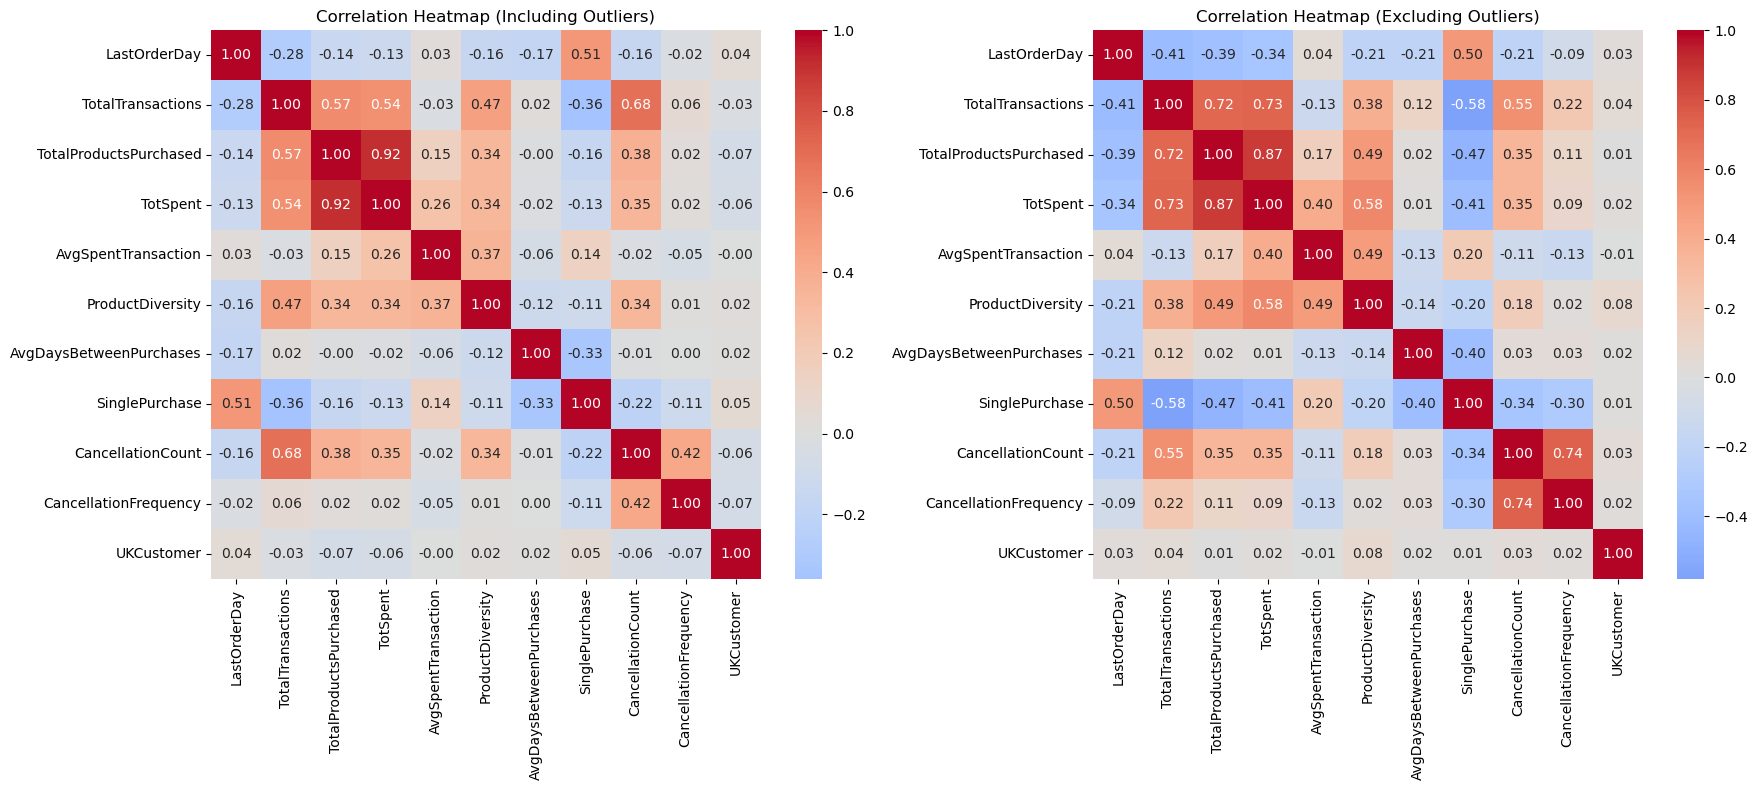

In [76]:
# Calculate correlation matrix for the dataframe including all rows
corr_all = dfc.drop(columns=["CustomerID", "IsOutlier"]).corr()

# Calculate correlation matrix for the dataframe excluding outliers
corr_no_outliers = dfc_no_outliers.drop(columns=["CustomerID", "IsOutlier"]).corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(corr_all, annot=True, cmap="coolwarm", fmt=".2f", center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap (Including Outliers)")

sns.heatmap(corr_no_outliers, annot=True, cmap="coolwarm", fmt=".2f", center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap (Excluding Outliers)")

plt.tight_layout()
plt.show()

**Correlation Heatmap Comparison**

Generally, the correlation plot excluding outliers presents more significant correlations in comparison to the first heatmap. This is the case for all correlations except ProductDiversity and TotalTransactions (0.47 in comparison to 0.36) and UKCustomer correlation to some features, however non of them in both cases surpass 0.07. 

Using the correlation plot excluding outliers is therefore, justified because it reveals more significant correlations among variables compared to the plot including outliers. By excluding outliers, the correlations become more reliable and representative of the underlying relationships within the data. This allows for a more accurate interpretation of the data and better informs the segmentation process in the unsupervised learning model.

**Correlation Heatmap Excluding Outliers Interpretation**

- LastOrderDay has a strong negative correlation with TotalTransactions (-0.42), suggesting that customers who have ordered more recently tend to have a higher number of transactions in total. This could indicate that more active customers make more frequent purchases.

- A robust positive correlation exists between TotalTransactions and TotalProductsPurchased (0.70), and between TotalProductsPurchased and TotSpent (0.87), indicating that customers who engage in more transactions not only buy more products but also contribute to a higher total expenditure.

- TotalTransactions shows a strong positive correlation with ProductDiversity (0.36), implying that customers who transact more frequently also tend to buy a more diverse range of products.

- SinglePurchase customers show a strong negative correlation with LastOrderDay (-0.51), TotalTransactions (-0.58), and TotalProductsPurchased (-0.45), suggesting that those who have made only one purchase tend to have their purchase further in the past and have lower total transactions and products purchased, which is consistent with their single-purchase status.

- There's a notable positive correlation between CancellationCount and TotalTransactions (0.59), indicating that customers with more transactions may also have a higher number of cancellations. This might reflect that with an increase in purchase frequency, the likelihood of returns or cancellations also increases. This is further reinforced by the negative correlation between CancellationCount and SinglePurchase (-0.36).

- CancellationCount is also strongly correlated with CancellationFrequency (0.76), reinforcing the concept that customers who cancel more frequently naturally have a higher count of cancellations.

- Interestingly, CancellationFrequency shows no strong correlation with most other features, suggesting that the rate at which cancellations occur does not directly relate to the overall transactional activity, such as the total amount spent or the diversity of products purchased.

- The variable AvgDaysBetweenPurchases has minimal to no correlation with other variables, indicating that the average interval between purchases does not strongly influence the overall spending behavior or the diversity of products purchased.

- The heatmap also shows that being a UKCustomer has little to no correlation with any of the transactional behaviors, which could imply that the geographic location within the UK is not a distinguishing factor in how customers interact with FarTrend's e-commerce platform.

In summary, the heatmap suggests that the more active a customer is in terms of transactions, the more diverse and numerous their purchases, leading to higher overall spending. Frequent shoppers also show a propensity for more cancellations, which might be a natural result of higher transaction volumes. Single-purchase customers are clearly distinguishable by their transaction patterns, highlighting a potential segment for targeted engagement strategies. Lastly, the average frequency of purchases doesn't seem to be a significant factor in determining how much customers spend or the range of products they purchase, indicating other factors might be at play in influencing customer purchasing behavior.

##### Standardizing Variables

Standardization of features is essential as it ensures that each feature has a mean of 0 and a standard deviation of 1, thereby bringing all features to a common scale. This process is crucial, especially when using distance-based algorithms like K-means clustering and dimensionality reduction methods like PCA. Unlike normalization, which scales the features to a specific range (typically between 0 and 1), standardization does not rely on the minimum and maximum values of the features. Instead, it focuses on making it suitable for algorithms that rely on distance and variance. This prepares the data for further analysis and ensures that each feature contributes equally to the model's learning process, regardless of its original scale.

In [77]:
dfc_no_outliers.drop(["IsOutlier"], axis = 1, inplace = True)

C:\Users\julia\AppData\Local\Temp\ipykernel_21844\2542244070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_no_outliers.drop(["IsOutlier"], axis = 1, inplace = True)


In [78]:
"""
Standirdizing all those features which are not already in binary format to ensure that each feature contributes equally to the analysis. This process converts their values 
to a common scale with a mean of 0 and a standard deviation of 1.  
It was decided to standirdize rather than normalize features since the min-max value of all variables are not known. Standirdization allows to not have to rely on assumptions 
about the data distribution or the knowledge of the range of values.
The two columns "CustomerID" "SinglePurchase" and "UKCustomer" will be excluded because the first acts as a unique identifier and the second is already a binary feature so standardizing is not necessary.
"""
scaler = StandardScaler()

cols_standardize = ["LastOrderDay", "TotalTransactions", "TotalProductsPurchased", "TotSpent", "AvgSpentTransaction", "ProductDiversity", "AvgDaysBetweenPurchases", "CancellationCount", "CancellationFrequency"]

# Standardize and create a new DataFrame with the same index as the original df
dfc_stand = pd.DataFrame(scaler.fit_transform(dfc_no_outliers[cols_standardize]), columns=cols_standardize, index=dfc_no_outliers.index)

# Add all features back into one dataframe
dfc_standardized = dfc_no_outliers.copy()
dfc_standardized[cols_standardize] = dfc_stand

dfc_standardized.head()

CustomerID  LastOrderDay  TotalTransactions  TotalProductsPurchased  \
0    12346.0      1.851893          -0.318003               -0.738400   
2    12348.0     -0.400857           0.228711                2.582969   
3    12349.0     -0.914484          -0.591360                0.158882   
4    12350.0      1.716728          -0.591360               -0.459246   
5    12352.0     -0.752286           1.322138               -0.078969   

   TotSpent  AvgSpentTransaction  ProductDiversity  AvgDaysBetweenPurchases  \
0 -0.823151            -0.778849         -0.848655                -0.402149   
2  0.478594             0.009090         -0.537171                 1.918733   
3  0.442059             2.284449          0.257113                -0.402149   
4 -0.567600            -0.160115         -0.615042                -0.402149   
5  0.275274            -0.446414          0.023500                 0.179247   

   SinglePurchase  CancellationCount  CancellationFrequency  UKCustomer  
0               1           0.079372               0.839647           1  
2               0          -0.362972              -0.369929           0  
3               1          -0.362972              -0.369929           0  
4               1          -0.362972              -0.369929           0  
5               0           2.733430               1.746829           0

#### Q1.2 Please describe in two paragraphs the main data insights. Connect the insight with the business  (10 points)

The analysis of the provided data and charts offers insightful revelations on the operational facets of FarTrend that necessitate refinement. The data reveals that the average transaction involves approximately 9.55 products, each priced at about 4.61 pounds, highlighting a pattern where **consumers favor volume purchases**, a behavior possibly propelled by the perceived value and bulk buying incentives. FarTrend’s **diverse catalog**, featuring a broad array of 4070 unique items, seems to cater to this buying trend, potentially encompassing products that are part of a series or commonly used, thus encouraging larger basket sizes. Moreover, the data unveils a **balanced split among customers regarding repeat purchases**. This dualism presents FarTrend with a prime opportunity to **convert one-time buyers into repeat customers through tailored marketing initiatives**. On the other hand, the recency of the data (limited to the previous year) **restricts a long-term view of customer purchasing patterns**. Coupled with the fact that the overwhelming majority of transactions originate from the UK, accounting for 91.4% of the total customer base, there is an evident **concentration risk** should market conditions in the UK fluctuate. A significant challenge lies in the 25% of transactions **missing customer IDs**, which obscures a complete understanding of consumer behaviors and impairs longitudinal studies of purchasing trends. The data set is further compromised by the presence of rows which are exact **duplicates** except for the Quantity, **anomalies in stock codes**, and the **casual nature of product description entries** (including informal language and grammatical errors), suggesting an area ripe for improvement in data governance. By elevating data entry protocols or adopting more robust systems, FarTrend could significantly enhance the accuracy and uniformity of their data, paving the way for strategic insights and informed decision-making.

In light of these insights, FarTrend has many opportunities and challenges they need to face in order to become more profitable and streamline their business opertaions. By focusing on customer engagement and retention, the company can aim to convert one-time buyers into repeat customers; diversifying its customer base beyond the UK market could also reduce potential risks associated with relying on a single region; and refining data management protocols for better customer intelligence and operational effectiveness. Such strategic amendments have the potential to extend market penetration and bolster customer relationship management, ultimately catalyzing sustained growth and business resilience. The upward trend in monthly and quarterly revenues in the past year corroborates FarTrend's expansion trajectory, underscoring the imperative to institute standardized processes and solidify customer retention strategies to nurture loyalty and encourage repeat business.

## Question 2: Segment the clients based on their purchase profile (35 points)

#### Q2.1 Build a baseline model to segment the customers. (15 points)

Justify why k-means clustering is a good choice and define quickly what type of model it is, and why Dimensionality Reduction (because of the high degree of multicollinearity detected amoung features) and defining k will be done (based on models but also in perspective of the business scope).

##### Feature Selection through Dimensionality Reduction - PCA

Feature selection is crucial as it reduces overfitting by eliminating redundant data, improves model accuracy by removing misleading information, and cuts down training time by simplifying algorithm complexity. This will be done through dimensionality reduction using PCA method.

Dimensionality reduction is the process of converting a dataset with a large number of variables into one with fewer variables, while retaining as much of the significant information as possible. It simplifies the dataset, making it easier to visualize, analyze, and interpret, while also speeding up machine learning algorithms without a significant loss of information.

PCA is one of the most widely used methods for dimensionality reduction and is particularly relevant for FarTrend as it does not require labeled data, helps remove redundant information from multicollinear features, will lead to an improved clustering with distance-based algorithms, makes it easier to visualize complex data in a lower dimensional space, deals well with linear data and is computationally less expensive than e.g. t-SNE.

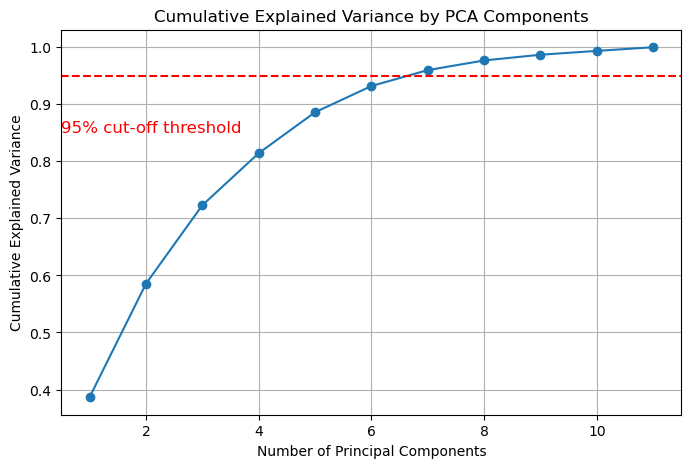

Number of components that explain at least 95% of the variance: 7


In [79]:
"""
Choosing the number of principal components (k value) in PCA involves a trade-off between information retention and model 
simplicity. Therefore, to find the optimal k value, a chart will be plotted that shows the performance for each k-value 
in capturing the variability of the model.
"""
dfc_standardized.set_index("CustomerID", inplace = True)

pca = PCA()
pca.fit(dfc_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line for 95% explained variance
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=12)
plt.grid(True)
plt.show()

# Find the number of components that explain at least 95% of the variance
k_95_percent = np.where(cumulative_variance >= 0.95)[0][0] + 1
print(f"Number of components that explain at least 95% of the variance: {k_95_percent}")

In [80]:
# Initialize PCA object, with n_components = 7
pca = PCA(n_components = 7)

pca.fit(dfc_standardized)

dfcpca = pca.transform(dfc_standardized)

# Convert the PCA-applied data back to a DataFrame & set index to CustomerID
dfc_pca = pd.DataFrame(dfcpca, columns=["PC" + str(i) for i in range(1, pca.n_components_ + 1)])

dfc_pca.index = dfc_standardized.index

In [81]:
dfc_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
CustomerID                                                               
12346.0    -1.664682  1.048603 -1.343821 -0.353069  1.100860 -0.089926   
12348.0     1.426209  0.057158  2.049456  0.473666  1.116042  1.037401   
12349.0     0.311856 -1.930427 -0.214807  0.981722 -1.089675  1.108200   
12350.0    -1.728688 -0.244588 -0.712102 -0.386190  1.085028  0.102403   
12352.0     2.147454  2.501528 -1.106816  0.375053 -0.402825 -0.113362   

                 PC7  
CustomerID            
12346.0    -0.216693  
12348.0    -1.148508  
12349.0     0.368864  
12350.0     0.004712  
12352.0     0.939451

##### Defining optimal number of clusters

###### Elbow Method

The Elbow Method determines the optimal number of clusters by plotting the sum of squared distances between data points and their assigned centroids against different k values, identifying the point where further increasing k provides diminishing returns in reducing inertia, signifying the ideal number of clusters. 

The Elbow Method is crucial in clustering analysis as it helps avoid both underfitting and overfitting by providing a clear indication of the appropriate number of clusters to use, thereby ensuring the optimal segmentation of the dataset.

The “elbow” point is identified at the spot where the decrease in WCSS starts to level off, suggesting that adding more clusters beyond this point does not significantly improve the fitting of the model.

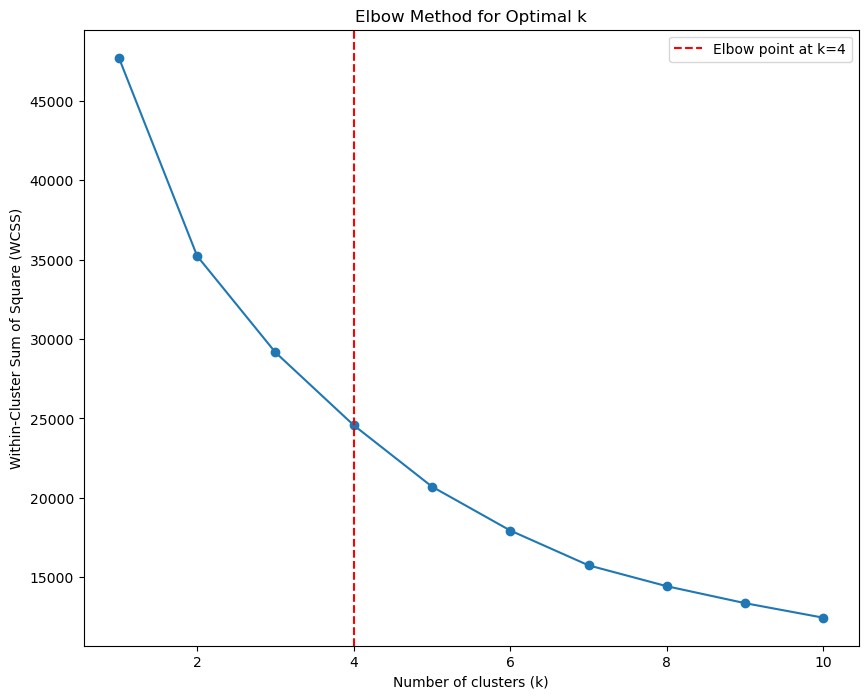

In [82]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(dfc_pca)
    wcss.append(kmeans.inertia_)

kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
elbow_point = kn.knee

# Now plot the Elbow graph and add a line for the elbow point
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Square (WCSS)')
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow point at k={elbow_point}')
plt.legend()
plt.show()

Observing the results from the elbow method, the elbow point is located 4 clusters. However, the decrease in WCSS is fairly constant between 3 and 7 and therefore, does not show a distinct elbow point (where the slope changes in an evident way). Due to this, a further analysis using the Silhouette number will be taken, and based on those results a number of clusters considering also the business problem will be chosen.

###### Silhouette Method

The advantage of the Silhouette method lies in providing insight into the separation distance between the resulting clusters, allowing for a more informed decision on the number of clusters by not just identifying cohesion within clusters but also separation between them. While the Elbow Method is intuitive and quick, identifying the 'elbow' can be subjective, whereas the silhouette method provides a more objective criterion through its scoring mechanism.

A general rule of thumb is that a silhouette score above 0.5 indicates a good clustering, a silhouette score below 0.25 indicates a bad clustering, and a silhouette score between 0.25 and 0.5 indicates a fair clustering.

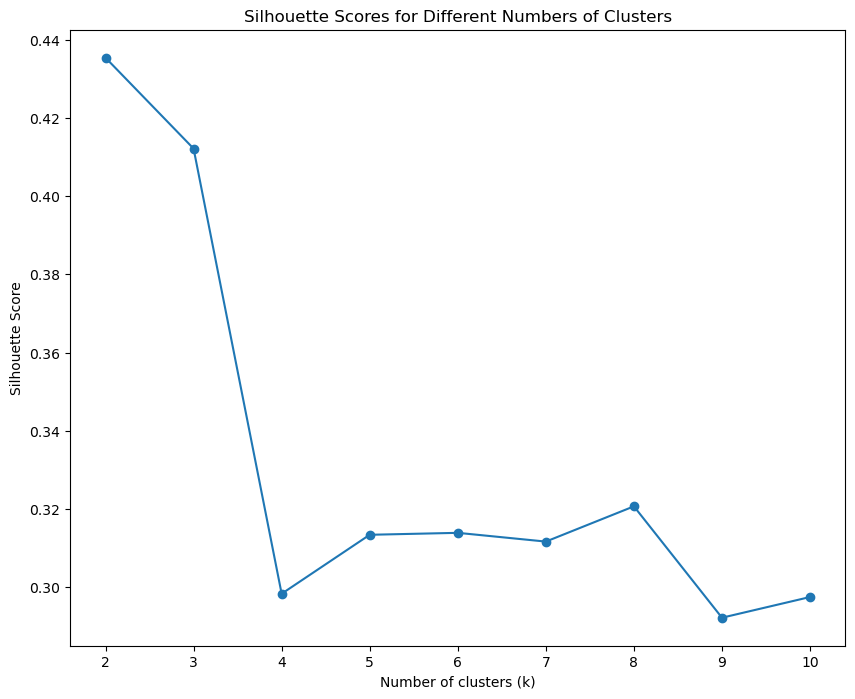

In [83]:
silhouette_scores = []

# Try different numbers of clusters
for i in range(2, 11):  # silhouette score cannot be computed with only one cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(dfc_pca)
    score = silhouette_score(dfc_pca, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores to observe the optimal number of clusters
plt.figure(figsize=(10, 8))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

The Silhouette method suggests selecting the k value corresponding to the highest silhouette score, which in this case is 2 clusters with a Silhouette Score of nearly 0.44. Conversely, the Elbow Method indicates that 4 clusters would be optimal. Given the discrepant results from both models, a dendogram diagram will be plotted in order to better visualize how the data is related. Thereafter, the final choice of k-value will be made considering the business context and project objectives.

###### Dendogram

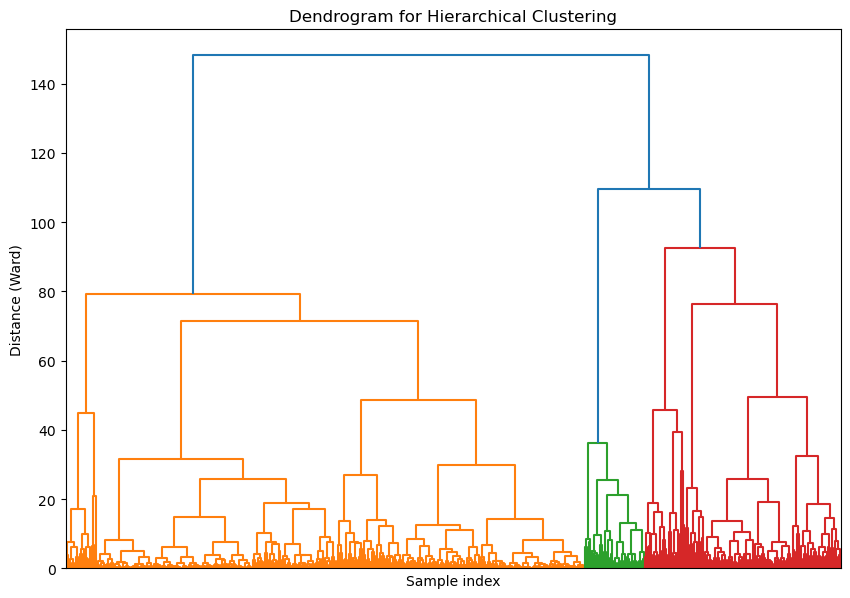

In [84]:
# Generate the linkage matrix using the Ward variance minimization algorithm
Z = linkage(dfc_pca, method="ward", metric="euclidean")

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, no_labels=True)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample index")
plt.ylabel("Distance (Ward)")
plt.show()

Choosing the number of clusters presents a trade-off between granularity and interpretability. While opting for only 2 clusters, as suggested by the Silhouette Score, might oversimplify the segmentation of FarTrend customers, dividing them into 4 groups based on the elbow method could introduce excessive complexity due to the 0.30 Silhouette Score. Therefore, in accordance with the dendrogram analysis, three clusters will be used in the models. This choice maintains a respectable silhouette score above 0.41 while exhibiting a moderate deviation in within-cluster sum of squares (WCSS), striking a balance between granularity and interpretability.

With three segments, the e-commerce company can differentiate possibly between high-value, medium-value, and low-value customers, enabling tailored marketing strategies, personalized recommendations, and targeted retention efforts. This approach balances the need for detailed customer insights with the practicality of implementation, making it well-suited for optimizing business outcomes in the dynamic e-commerce landscape.

##### Baseline Model - K-Means Clustering

The following evaluation metrics will be adopted to compare the performance between the baseline and the second model:
- The silhouette score provides a measure of how well-defined and distinct the clusters are, making it valuable for assessing the overall quality of clustering. 

- The Davies-Bouldin score offers insights into the compactness and separation of clusters, aiding in the comparison of models based on their intra-cluster and inter-cluster distances. 

- The Calinski-Harabasz score evaluates the ratio of between-cluster dispersion to within-cluster dispersion, enabling comparisons of clustering models in terms of their cluster density and separation. 

By considering these metrics collectively, we can effectively compare the performance of different clustering models and select the one that best suits our specific clustering objectives and dataset characteristics.

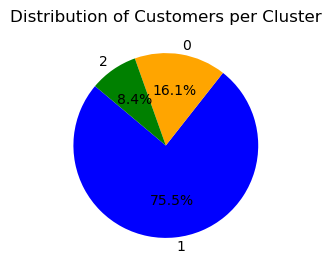

In [85]:
means = KMeans(n_clusters=3, init="k-means++", max_iter=300, n_init=10, random_state=0)
means.fit(dfc_pca)

# Assign cluster labels to your dataframe
dfc_pca["Cluster_1"] = means.labels_

# Prepare the cluster pie chart data
cluster_pie = dfc_pca["Cluster_1"].value_counts()

# Plot the frequencies on a pie chart
plt.figure(figsize=(4, 3))
plt.pie(cluster_pie, labels=cluster_pie.index, autopct="%1.1f%%", startangle=140, colors=["blue", "orange", "green"])
plt.title("Distribution of Customers per Cluster")
plt.show()

In [86]:
"""
Plotting a 3D pairplot to see the relationship amoung the 3 most importantx principal components for the baseline model.
"""
# Create the scatter plot trace for each cluster
scatter_traces = []
for cluster, color in zip(dfc_pca['Cluster_1'].unique(), ["blue", "orange", "green"]):
    cluster_data = dfc_pca[dfc_pca['Cluster_1'] == cluster]
    scatter_trace = go.Scatter3d(
        x=cluster_data['PC1'],
        y=cluster_data['PC2'],
        z=cluster_data['PC3'],
        mode='markers',
        marker=dict(color=color, size=2),  # Adjust the size of the dots here
        name=f'Cluster {cluster}'
    )
    scatter_traces.append(scatter_trace)

# Create the layout
layout = go.Layout(
    title='3D PCA Scatter Plot',
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3')
    ),
    # Adjust the size of the graph here
    width=800,
    height=600
)

# Create the figure
fig = go.Figure(data=scatter_traces, layout=layout)

# Show the figure
fig.show()

In [87]:
dfc_pca_features = dfc_pca.drop(["Cluster_1"], axis = 1)

# Silhouette score
silhouette = silhouette_score(dfc_pca_features, dfc_pca["Cluster_1"])
print("Silhouette Score:", silhouette)

# Davies-Bouldin score
davies_bouldin = davies_bouldin_score(dfc_pca_features, dfc_pca["Cluster_1"])
print("Davies-Bouldin Score:", davies_bouldin)

# Calinski-Harabasz score
calinski_harabasz = calinski_harabasz_score(dfc_pca_features, dfc_pca["Cluster_1"])
print("Calinski-Harabasz Score:", calinski_harabasz)

Silhouette Score: 0.4121556953668264
Davies-Bouldin Score: 1.0975078475306521
Calinski-Harabasz Score: 1698.3512695947852


- A high Silhouette Score indicates well-separated clusters, with scores closer to 1 suggesting dense and well-separated clusters. In this case, a score of 0.412 suggests reasonably good cluster separation.

- The Davies-Bouldin Score with lower values indicates better clustering. A score of 1.098 suggests that the clusters are reasonably well-separated and distinct.

- For the Calinski-Harabasz Score, higher scores indicate better-defined clusters. A score of 1698.351 suggests that the clusters are well-separated and distinct.

Overall, the evaluation metrics indicate that the clustering model performs reasonably well in creating distinct and well-separated clusters, with the Silhouette Score and Calinski-Harabasz Score indicating strong cluster separation. These metrics provide valuable insights into the effectiveness of the clustering algorithm in segmenting the data.

#### Q2.2 Build a second model to segment customers and compare the performance. (10 points)

##### Secondary Model - Hierarchical Clustering

Hierarchical Clustering: It builds a tree of clusters where each node represents a cluster. This can provide insights into the hierarchical structure of your data.

C:\Users\julia\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



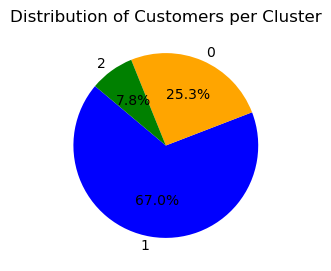

In [88]:
features = dfc_pca.drop(["Cluster_1"], axis=1)

n_clusters = 3
hclust = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward")
cluster_labels = hclust.fit_predict(features)

# Assign hierarchical clustering results to 'Cluster_2'
dfc_pca["Cluster_2"] = cluster_labels

# Prepare the data for the pie chart
cluster_pie2 = dfc_pca["Cluster_2"].value_counts()

# Plot the frequencies on a pie chart
plt.figure(figsize=(4, 3))
plt.pie(cluster_pie2, labels=cluster_pie.index, autopct="%1.1f%%", startangle=140, colors=["blue", "orange", "green"])
plt.title("Distribution of Customers per Cluster")
plt.show()

In [89]:
"""
Plotting a 3D pairplot to see the relationship amoung the 3 most importantx principal components for the baseline model.
"""
# Create the scatter plot trace
scatter_trace = go.Scatter3d(
    x=dfc_pca['PC1'],
    y=dfc_pca['PC2'],
    z=dfc_pca['PC3'],
    mode='markers',
    marker=dict(color=dfc_pca['Cluster_2'], size=2),  # Adjust the size of the dots here
)

# Create the layout
layout = go.Layout(
    title='3D PCA Scatter Plot',
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3')
    ),
    # Adjust the size of the graph here
    width=800,
    height=600
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the figure
fig.show()

In [90]:
dfc_pca_features = dfc_pca.drop(["Cluster_1", "Cluster_2"], axis = 1)

# Silhouette score
silhouette = silhouette_score(dfc_pca_features, dfc_pca["Cluster_2"])
print("Silhouette Score:", silhouette)

# Davies-Bouldin score
davies_bouldin = davies_bouldin_score(dfc_pca_features, dfc_pca["Cluster_2"])
print("Davies-Bouldin Score:", davies_bouldin)

# Calinski-Harabasz score
calinski_harabasz = calinski_harabasz_score(dfc_pca_features, dfc_pca["Cluster_2"])
print("Calinski-Harabasz Score:", calinski_harabasz)

Silhouette Score: 0.36568918377790866
Davies-Bouldin Score: 1.2589335574829341
Calinski-Harabasz Score: 1472.9443453923475


##### Model Evaluation & Comparison

1. K-MEANS:

>**Silhouette Score: 0.4121556953668264**

>**Davies-Bouldin Score: 1.097507847530652**

>**Calinski-Harabasz Score: 1698.3512695947854**

2. HIERARCHICAL:

>Silhouette Score: 0.36568918377790866

>Davies-Bouldin Score: 1.2589335574829341

>Calinski-Harabasz Score: 1472.9443453923475


The second model has scored similar scores to the baseline model, where both methods produced reasonably good clustering results. However, the hierarchical clustering shows slightly worse results in all three metrics. [one more sentence on why this could be the case] 


For this reason, **the three Customer Segments identified in the K-Means Clustering will be used**. It is nonetheless important to consider that other Clustering models may have better results and that changing the various hyperparameters (e.g. the amount of clusters) could further improve the segmentation. 

##### Customer Segment Characteristics

Now that the three Customer Segments have been identified using the K-Means Clustering model, the next step encompasses understanding the different characteristics between these segments which will be the foundation of understanding how to create personalised strategies to capture and retain customers as well as increase their spending as much as possible.

In [91]:
"""
Before starting with the analysis the Cluster segmentation column will have to be joined into the dfc df. This will allow to compare the characteristic
between the three identified segments. A right join was chosen so only those customer IDs which have been segmented will be merged (however, also an outer
join could've been used since they should anyways contain the same customer IDs).
"""
dfc_k  = dfc.join(dfc_pca["Cluster_1"], on = "CustomerID", how = "right")
dfc_k.drop(["IsOutlier"], axis = 1, inplace = True)

In [92]:
"""
Describing each feature's statistics within their segment will give initial insights to the different characteristics of the data.
"""
dfc_k.loc[dfc_k["Cluster_1"] == 0].describe()

LastOrderDay  TotalTransactions  TotalProductsPurchased     TotSpent  \
count    857.000000         857.000000              857.000000   857.000000   
mean      30.826138           9.464411             1680.949825  2790.552637   
std       41.022775           4.973430              981.565215  1511.641537   
min        0.000000           2.000000                0.000000     0.000000   
25%        7.000000           6.000000             1021.000000  1727.170000   
50%       16.000000           8.000000             1476.000000  2427.320000   
75%       39.000000          12.000000             2070.000000  3465.670000   
max      306.000000          41.000000             7432.000000  9065.760000   

       AvgSpentTransaction  ProductDiversity  AvgDaysBetweenPurchases  \
count           857.000000        857.000000               857.000000   
mean            328.945333        116.774796                 2.157306   
std             182.968200         75.505582                 1.866650   
min               0.000000          4.000000                 0.010899   
25%             205.629000         66.000000                 1.035714   
50%             286.564000         99.000000                 1.694915   
75%             402.434000        148.000000                 2.613208   
max            1571.942500        448.000000                18.333333   

       SinglePurchase  CancellationCount  CancellationFrequency  UKCustomer  \
count           857.0         857.000000             857.000000  857.000000   
mean              0.0           3.634772               0.453115    0.947491   
std               0.0           4.345570               0.672877    0.223181   
min               0.0           0.000000               0.000000    0.000000   
25%               0.0           0.000000               0.000000    1.000000   
50%               0.0           2.000000               0.250000    1.000000   
75%               0.0           5.000000               0.571429    1.000000   
max               0.0          28.000000               5.500000    1.000000   

       Cluster_1  
count      857.0  
mean         0.0  
std          0.0  
min          0.0  
25%          0.0  
50%          0.0  
75%          0.0  
max          0.0

In [93]:
dfc_k.loc[dfc_k["Cluster_1"] == 1].describe()

LastOrderDay  TotalTransactions  TotalProductsPurchased     TotSpent  \
count   4031.000000        4031.000000             4031.000000  4031.000000   
mean     133.055817           2.052096              266.084098   465.030687   
std      112.787939           1.519032              288.294756   433.392300   
min        0.000000           1.000000             -303.000000  -464.900000   
25%       32.000000           1.000000               64.000000   150.975000   
50%       94.000000           1.000000              170.000000   347.000000   
75%      220.000000           3.000000              372.000000   660.710000   
max      373.000000          10.000000             2332.000000  3276.400000   

       AvgSpentTransaction  ProductDiversity  AvgDaysBetweenPurchases  \
count          4031.000000       4031.000000              4031.000000   
mean            235.084230         30.504341                 2.346109   
std             188.082842         30.055357                 5.975046   
min            -464.900000          1.000000                 0.000000   
25%             107.995000          9.000000                 0.000000   
50%             193.497500         22.000000                 0.000000   
75%             327.721667         43.000000                 2.433036   
max            1143.600000        232.000000                91.000000   

       SinglePurchase  CancellationCount  CancellationFrequency   UKCustomer  \
count     4031.000000         4031.00000            4031.000000  4031.000000   
mean         0.554701            0.31357               0.105996     0.927313   
std          0.497060            0.86217               0.325876     0.259654   
min          0.000000            0.00000               0.000000     0.000000   
25%          0.000000            0.00000               0.000000     1.000000   
50%          1.000000            0.00000               0.000000     1.000000   
75%          1.000000            0.00000               0.000000     1.000000   
max          1.000000            9.00000               4.000000     1.000000   

       Cluster_1  
count     4031.0  
mean         1.0  
std          0.0  
min          1.0  
25%          1.0  
50%          1.0  
75%          1.0  
max          1.0

In [94]:
dfc_k.loc[dfc_k["Cluster_1"] == 2].describe()

LastOrderDay  TotalTransactions  TotalProductsPurchased     TotSpent  \
count    451.000000         451.000000              451.000000   451.000000   
mean     166.665188           1.121951              565.015521  1766.896475   
std      100.702339           0.457755              354.148490   700.006504   
min        0.000000           1.000000              137.000000   770.840000   
25%       79.000000           1.000000              364.500000  1283.175000   
50%      155.000000           1.000000              463.000000  1559.520000   
75%      253.000000           1.000000              640.500000  2052.895000   
max      371.000000           4.000000             3233.000000  4314.180000   

       AvgSpentTransaction  ProductDiversity  AvgDaysBetweenPurchases  \
count           451.000000        451.000000               451.000000   
mean           1660.800187        162.368071                 0.081346   
std             685.164307         76.069192                 0.375654   
min             364.130000          1.000000                 0.000000   
25%            1221.725000        106.000000                 0.000000   
50%            1496.040000        165.000000                 0.000000   
75%            1919.310000        208.500000                 0.000000   
max            4314.180000        378.000000                 3.518519   

       SinglePurchase  CancellationCount  CancellationFrequency  UKCustomer  \
count      451.000000         451.000000             451.000000  451.000000   
mean         0.926829           0.004435               0.001848    0.962306   
std          0.260706           0.066519               0.028267    0.190667   
min          0.000000           0.000000               0.000000    0.000000   
25%          1.000000           0.000000               0.000000    1.000000   
50%          1.000000           0.000000               0.000000    1.000000   
75%          1.000000           0.000000               0.000000    1.000000   
max          1.000000           1.000000               0.500000    1.000000   

       Cluster_1  
count      451.0  
mean         2.0  
std          0.0  
min          2.0  
25%          2.0  
50%          2.0  
75%          2.0  
max          2.0

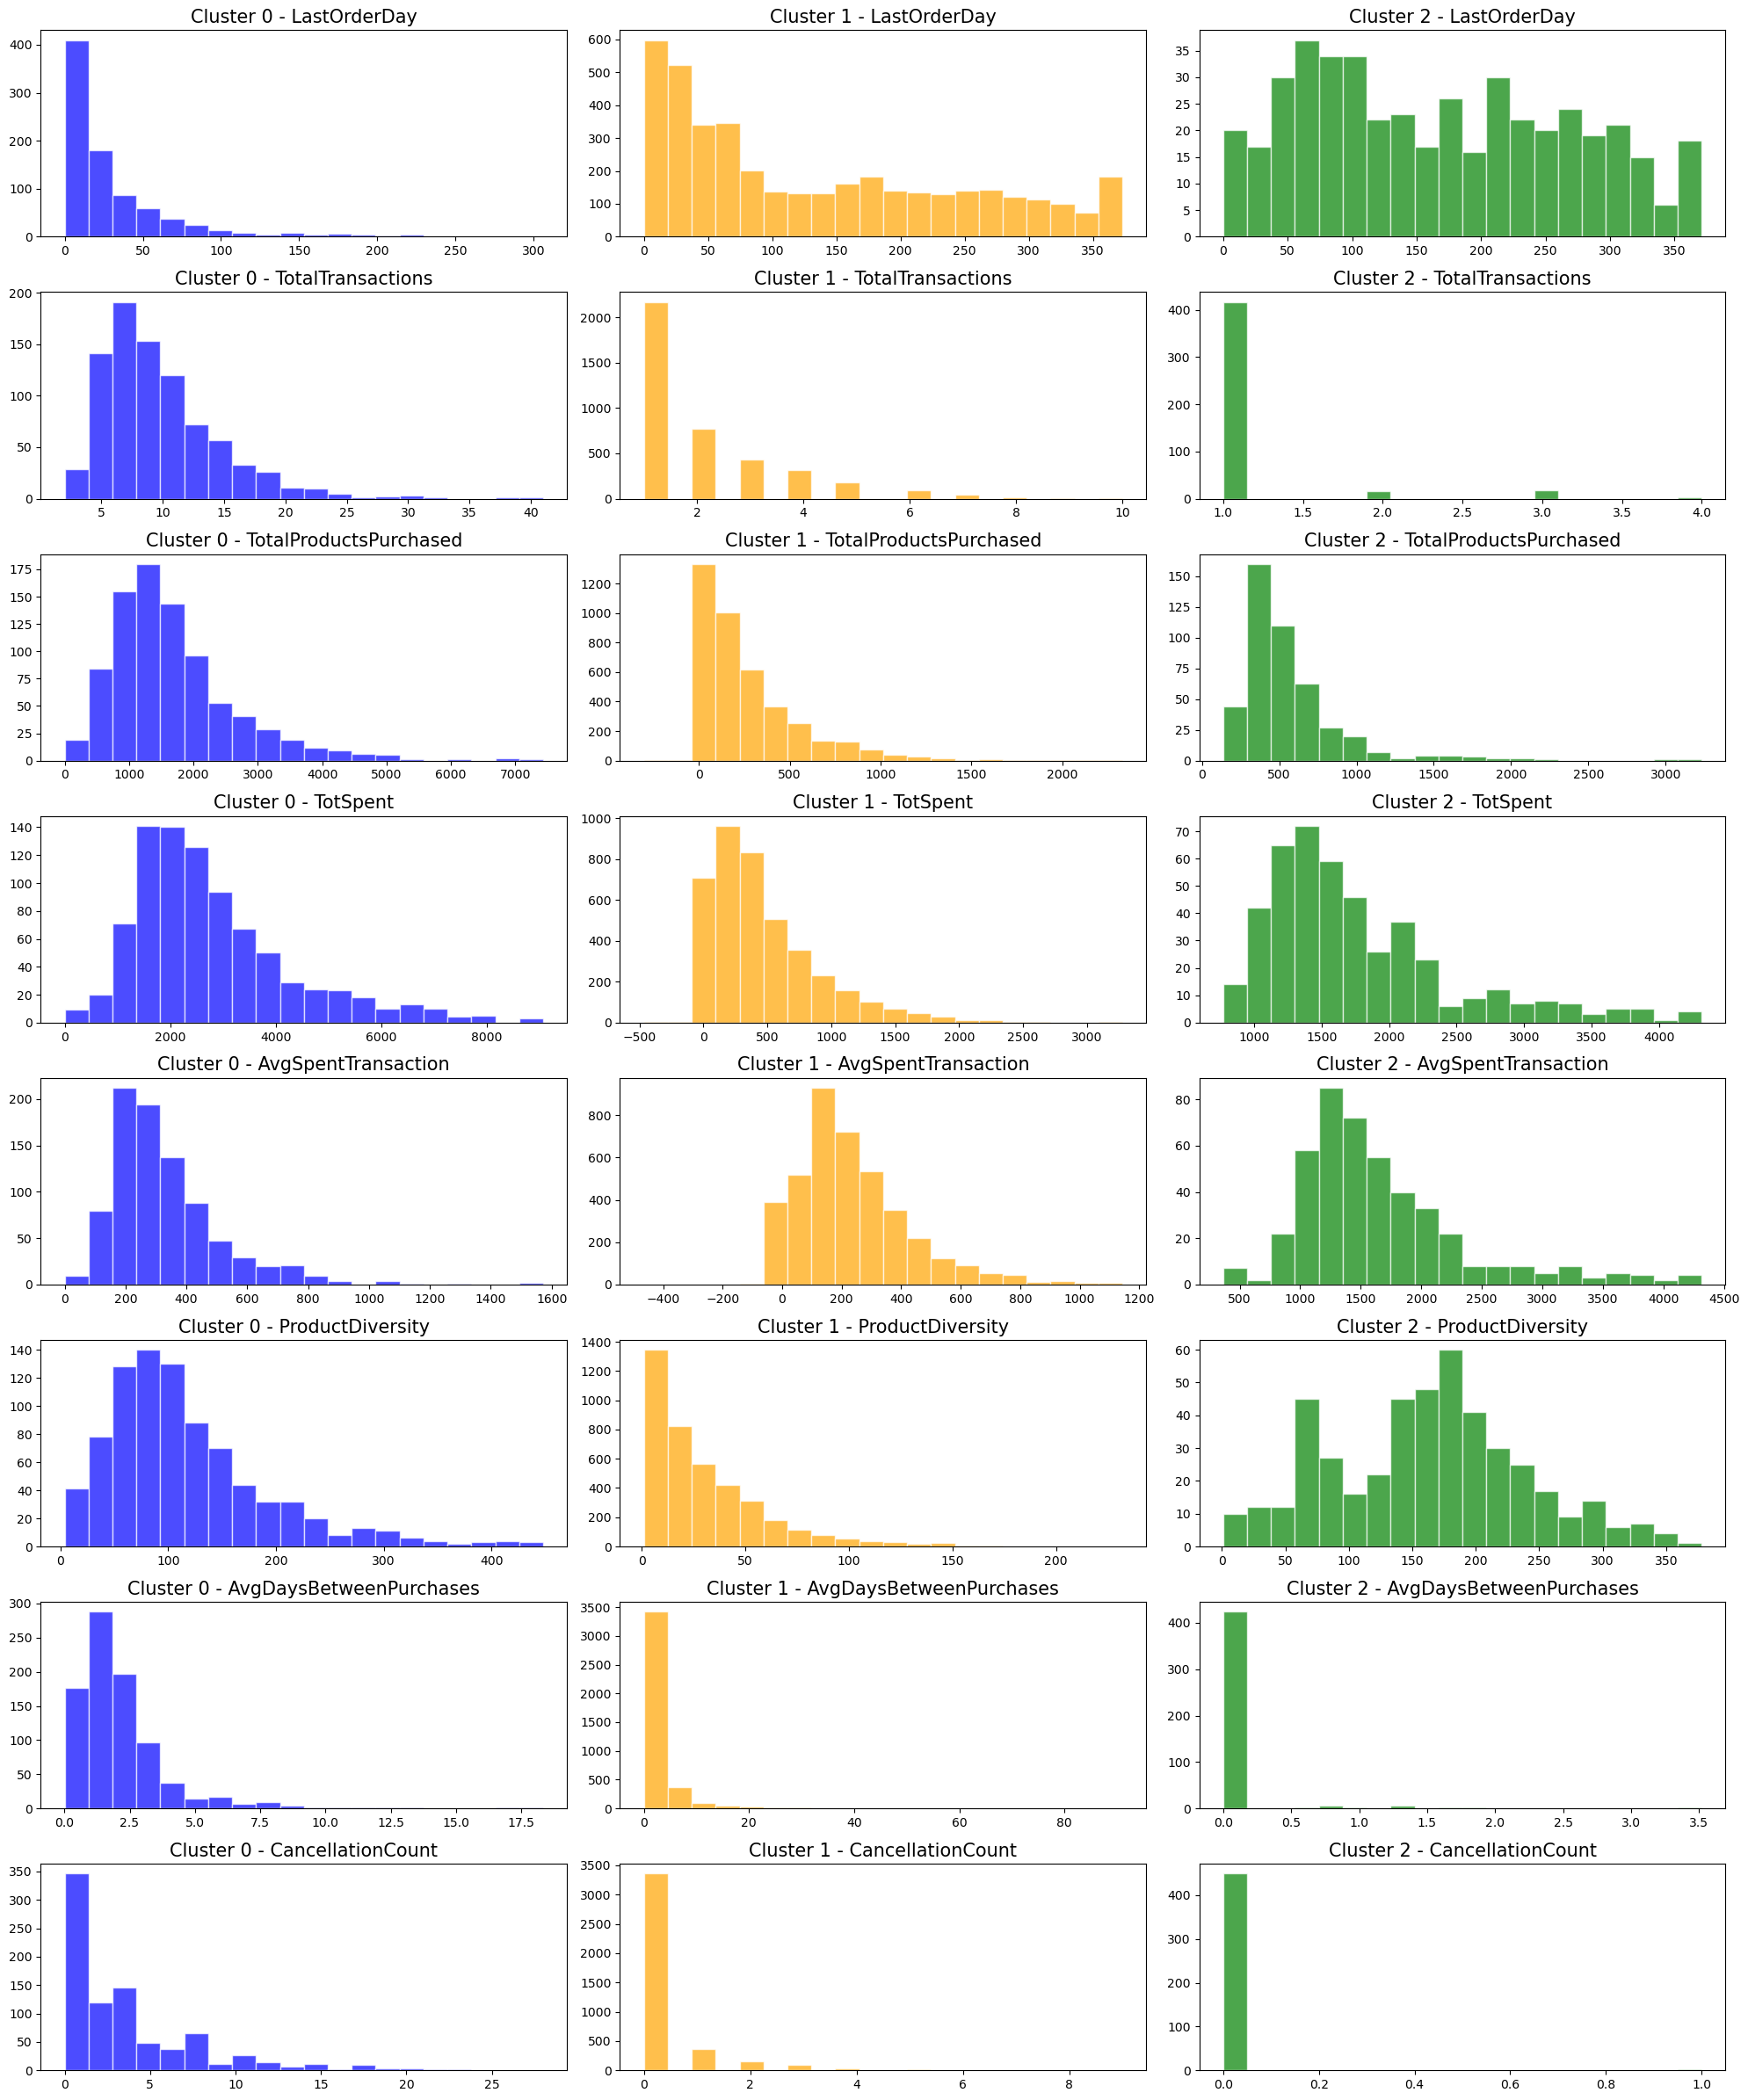

In [95]:
"""
Plotting each continuous variable onto three seperate histograms to understand better the different customer behaviours
"""
columns_plot = ["LastOrderDay", "TotalTransactions", "TotalProductsPurchased", "TotSpent", "AvgSpentTransaction", "ProductDiversity", "AvgDaysBetweenPurchases", "CancellationCount"]
clusters = dfc_k["Cluster_1"].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(columns_plot)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(columns_plot):
    for j, cluster in enumerate(clusters):
        data = dfc_k[dfc_k["Cluster_1"] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=["blue", "orange", "green"][j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f"Cluster {cluster} - {feature}", fontsize=15)
        axes[i, j].set_xlabel("")
        axes[i, j].set_ylabel("")

plt.tight_layout()
plt.show()

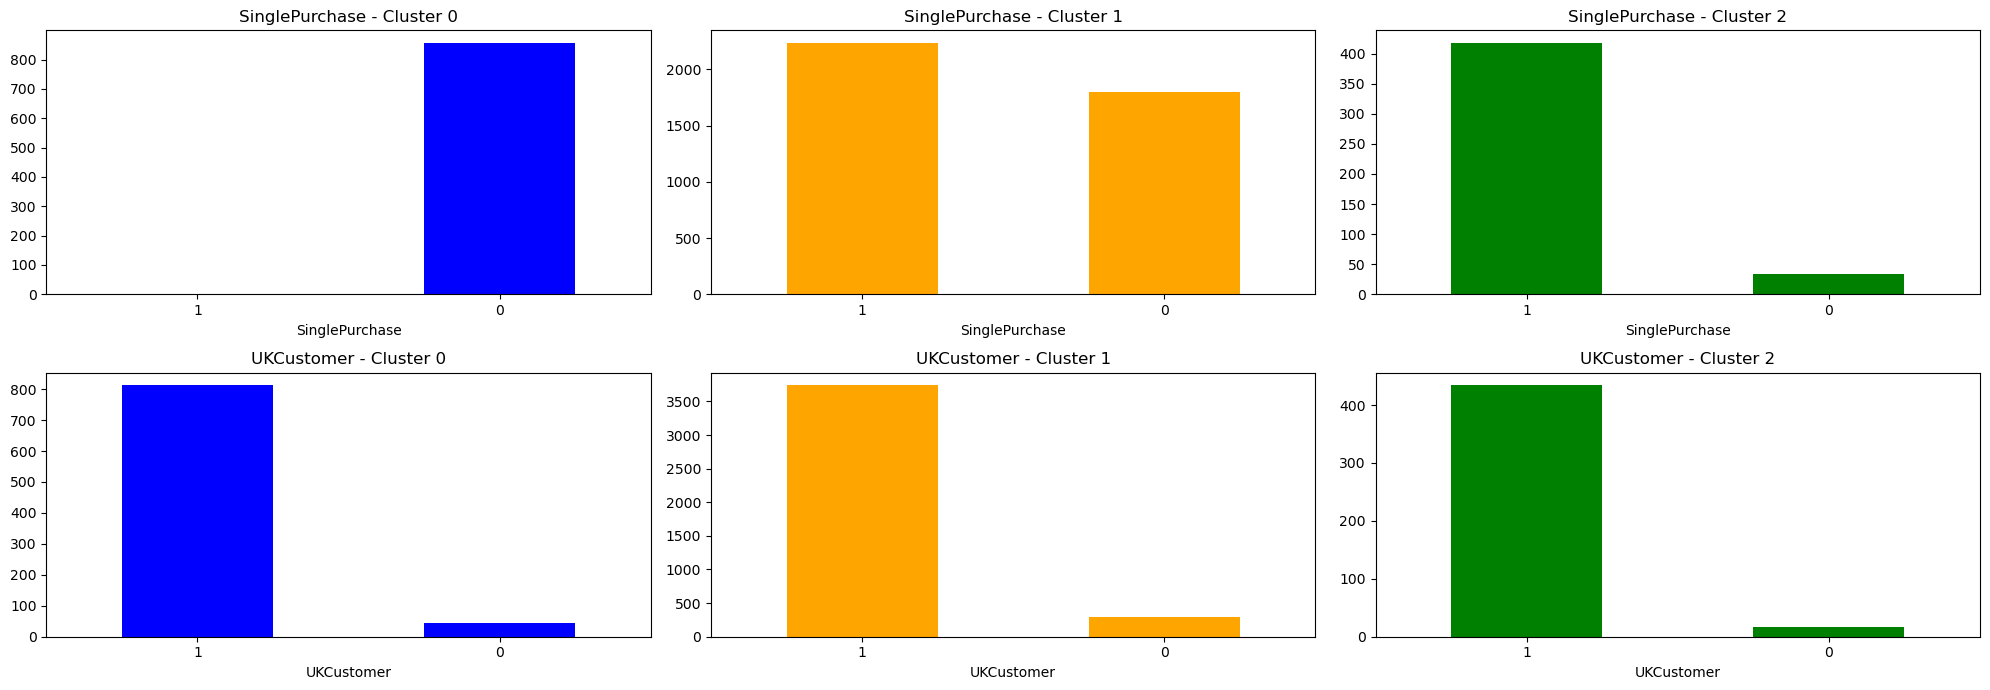

In [96]:
"""
Plotting a bar chart for the two binary variables (SinglePurchase & UKCustomer) based on the customer segment.
"""
dummy_cols = ["SinglePurchase", "UKCustomer"]
clusters = dfc_k["Cluster_1"].unique()
clusters.sort()

fig, axes = plt.subplots(nrows=len(dummy_cols), ncols=len(clusters), figsize=(20, 7))

for i, col in enumerate(dummy_cols):
    for j, cluster in enumerate(clusters):
        value_counts = dfc_k[dfc_k["Cluster_1"] == cluster][col].value_counts().reindex([1, 0])
        value_counts.plot(kind='bar', ax=axes[i, j], title=f"{col} - Cluster {cluster}", rot=0, color=["blue", "orange", "green"][j])

plt.tight_layout()
plt.show()

#### Q2.3 Based on the analysis, suggest a number of clusters and their characteristics to the head of marketing. Please justify your decisions. (10 points)

FarTrend's analysis of their e-commerce customer base reveals three distinct segments, each exhibiting unique purchasing behaviors that are instrumental for tailoring marketing strategies. 

1. **Occasional Customer**

The Occasional Customer segment, primarily characterized by minimal transactions and modest spending, represents those who engage with FarTrend sporadically. These customers tend to have a wide product interest but demonstrate a *low frequency of repeat purchases*.

Personalized marketing efforts could include *targeted promotions* on products based on their previous purchases or browsing history to encourage repeat visits. *Loyalty programs* or *limited-time offers* could incentivize them to make more frequent purchases.

More detailed information / justification:
- GENERAL TRANSACTION BEHAVIOUR (TotalTransactions, TotalProductsPurchased, SinglePurchase):
> Majority number of transactions lie between 1 and 3 transactions. 
> Majority number of total products purchased is between 64 and 372 and reach up to 2332.
> There is an almost equal distribution between customers have only ordered once or multiple times.

- FREQUENCY BEHAVIOUR (LastOrderDay, AvgDaysBetweenPurchases):
> The last order day varies greatly but generally stretches further back, indicating a mix of recent and older purchase history.
> Average days between purchases are low, suggesting many are either one-time buyers or have not repurchased recently.

- FINANCIAL BEHAVIOUR (TotSpent, AvgSpentTransaction):
> Total spent has a majority of customers spending below 662.97 pounds, with a spread up to 3276.40 pounds.
> Average spending per transaction is modest, predominantly below 328.39 pounds.

- PRODUCT PURCHASING BEHAVIOUR (ProductDiversity): 
> Product diversity is quite varied, with many customers purchasing a wide range of products, however the majority purchase between 9 to 43 different types of products.

- CANCELLATION BEHAVIOUR (CancellationCount, CancellationFrequency):
> Cancellation counts are generally low, with most customers having zero cancellations.

- DEMOGRAPHICS (UKCustomer):
> A large majority of customers in this cluster are from the UK.

2. **Active Customer**

Active Customers, on the other hand, show a strong commitment through *higher transaction volumes and significant spending*, highlighting their loyalty and frequent interaction with the platform. They tend to purchase a diverse range of products and have a consistent buying pattern. 

This segment would benefit from *exclusivity and early access to new products or sales*, reinforcing their loyalty and increasing their transaction frequency. *Personalized recommendations* and *rewards for referrals* can further enhance their engagement and spending.

More detailed information / justification:
- GENERAL TRANSACTION BEHAVIOUR (TotalTransactions, TotalProductsPurchased, SinglePurchase):
> This cluster exhibits higher transaction counts, with the majority between 6 and 12, and totals reaching up to 41.
> Majority number of total products purchased is between 1021 and 2070 and reach up to 7432. This number is significantly higher, showing that these customers buy in large quantities.
> All customers in this segment have ordered at least more than once, indicating repeat buyers.

- FREQUENCY BEHAVIOUR (LastOrderDay, AvgDaysBetweenPurchases):
> Last order days are more recent, indicating active or returning customers.
> Average days between purchases indicate consistent repurchasing habits.

- FINANCIAL BEHAVIOUR (TotSpent, AvgSpentTransaction):
> Customers here spend substantially more, with totals reaching up to 9065.76 pounds.
> The average transaction value is also higher (between 205.63 pounds and 402.43 pounds an reaching 1571.94 pounds), suggesting these customers make larger or more premium purchases.

- PRODUCT PURCHASING BEHAVIOUR (ProductDiversity):
> These customers show a high product diversity in their purchases between 66 and 148, indicating a broad interest in the product range.

- CANCELLATION BEHAVIOUR (CancellationCount, CancellationFrequency):
> Cancellation counts and frequencies are higher in this group, which may correlate with the higher number of transactions.

- DEMOGRAPHICS (UKCustomer):
> Almost all customers are from the UK, similar to Cluster 0.

3. **Focused Customer**

Lastly, the Focused Customer group is defined by their *one-time, significant purchases*. Despite their infrequent engagement, their transactions are considerable, focusing on specific needs or high-value items.

Focused Customers present a unique opportunity for *upselling* and *cross-selling*, particularly at the time of their significant purchases. Personalized follow-up communications highlighting complementary products or offering special deals on related items could entice additional purchases, converting one-time buyers into repeat customers.

More detailed information / justification:
- GENERAL TRANSACTION BEHAVIOUR (TotalTransactions, TotalProductsPurchased, SinglePurchase):
> Dominated by one-time purchasers with the majority having only 1 transaction.
> Majority number of total products purchased is between 364 and 634 and reach up to 3233. This range is less than Cluster 1 but higher than Cluster 0, indicating these may be moderate one-time buyers.

- FREQUENCY BEHAVIOUR (LastOrderDay, AvgDaysBetweenPurchases):
> Last order days spread across a wide range, but with a tendency towards older purchases, suggesting a less active customer base.
> The average days between purchases are near-zero, reinforcing the one-time purchase pattern.

- FINANCIAL BEHAVIOUR (TotSpent, AvgSpentTransaction):
> The total spent falls in a medium range, with most under 2052.11 pounds, but can reach over 4314.18 pounds.
> Average spending per transaction varies but is generally high (the highest of the three segments), indicating single purchases may be significant in value.

- PRODUCT PURCHASING BEHAVIOUR (ProductDiversity): 
> Product diversity is substantial but not as extensive as Cluster 1, which fits the profile of one-time, focused buyers.

- CANCELLATION BEHAVIOUR (CancellationCount, CancellationFrequency):
> There is a very low cancellation rate where the majority have never cancelled. This reflects that the one-time, focused buyers know what they want and most of the time go through with it.

- DEMOGRAPHICS (UKCustomer):
> Similar to the other two segments, the majority of customers are from UK.

## Question 3: Create a recommendation system that helps the company to increase sales (35 points)


#### Q3.1 Build the recommendation system. (25 points)

The goal of this recommendation system is to predict future purchases of new customers within their first year. Since we have successfully segmented our customer base into Occasional Customer, Active Customer, and Focused Customer segments but lack explicit user-item interaction ratings or reviews, we'll leverage a form of **item-based collaborative filtering** that focuses on product similarities based on purchase patterns.

The recommendation strategy will involve:

- Identifying Item Similarities: Calculating pairwise similarities between products based on the patterns in which customers purchase them. This is achieved through the construction of an item similarity matrix using cosine similarity measures.
- Generating Recommendations: For each customer, the system will identify products they have not yet purchased but are similar to items they have shown an interest in, based on the similarity scores in the matrix.
- Enhancing Recommendations with Product Descriptions: To make the recommendations more accessible and actionable, each suggested item's stock code will be mapped to its description, thereby providing clear and understandable recommendations to the customers.
- Dynamic Updating: As new purchase data becomes available, the item similarity matrix and, consequently, the recommendations will be updated. This ensures that the recommendations remain relevant and reflect the latest trends and customer preferences.

The recommendation model will be trained using a **train-test-split**. This will therefore train the model on 80% of the data, and then apply the recommendations to the remaining 20%. This will allow to assess the accuracy of the model in predicting products which the consumer may buy.

The model will be using **Cosine similarity**, an effective method for e-commerce recommendation models due to its proficiency in handling sparse data, ensuring scale invariance, and providing efficient computations. It excels in high-dimensional spaces by focusing on purchase patterns rather than volumes, making it ideal for personalizing recommendations across both popular and niche products. Additionally, its ability to perform well with segmented customer data allows for more tailored recommendations within specific customer groups, enhancing the overall shopping experience by aligning closely with individual purchasing habits. This method's straightforward interpretability further aids in marketing strategies and stakeholder communication, ensuring relevancy and scalability as the company grows.

##### Recommendation System

In [97]:
"""
Merging relevant columns together from the transaction database with the respective Customer Segment the transaction apartains to. There is no need
to exclude the outlier CustomerIDs identified beforehand thanks to the method right merge which only adds those CustomerIDs to the new dataframe
which are included in dfc_pca (which already only includes the non-outlier IDs).
"""
df_k = df[["InvoiceNo", "StockCode", "Description", "TotalQuantity", "CustomerID"]].join(dfc_pca["Cluster_1"], on = "CustomerID", how = "right")
df_k.head()

InvoiceNo StockCode                      Description  TotalQuantity  \
61619    541431     23166   MEDIUM CERAMIC TOP STORAGE JAR          74215   
61624   C541433     23166   MEDIUM CERAMIC TOP STORAGE JAR         -74215   
34083    539318     84992   72 SWEETHEART FAIRY CAKE CASES             72   
34084    539318     22951  60 CAKE CASES DOLLY GIRL DESIGN             72   
34085    539318     84991      60 TEATIME FAIRY CAKE CASES            144   

      CustomerID  Cluster_1  
61619    12346.0          1  
61624    12346.0          1  
34083    12348.0          1  
34084    12348.0          1  
34085    12348.0          1

In [98]:
"""
Ensuring CustomerID and StockCode are strings prevents potential issues with numerical operations and facilitates handling them as categorical identifiers.
"""
df_k["CustomerID"] = df_k["CustomerID"].astype(str)
df_k["StockCode"] = df_k["StockCode"].astype(str)

In [99]:
"""
Prepare the training and testing sets, and looking at their respective lengths. The best practice of train: 80% and test: 20% was adopted.
"""
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df_k, test_size = 0.2, random_state = 42)

print("The size of the training set is composed of", len(train_df), "rows. \n")
print("The size of the testing set is composed of", len(test_df), "rows.")

The size of the training set is composed of 288121 rows. 

The size of the testing set is composed of 72031 rows.


In [100]:
"""
Creating an item similarity matrix is a key step in collaborative filtering. By pivoting the training set data and calculating cosine similarities 
between items, this process identifies how similar products are to each other based on customer purchasing patterns.
"""
# Creating a pivot table from the training set
item_customer_matrix_train = train_df.pivot_table(index="StockCode", columns="CustomerID", values="TotalQuantity", fill_value=0, aggfunc="sum")

# Converting the pivot table to a sparse matrix for memory efficiency
sparse_item_customer_matrix_train = csr_matrix(item_customer_matrix_train)

# Computing the cosine similarity matrix
cosine_sim_train = cosine_similarity(sparse_item_customer_matrix_train)

# Converting the cosine similarity matrix to a DataFrame
item_sim_df_train = pd.DataFrame(cosine_sim_train, index=item_customer_matrix_train.index, columns=item_customer_matrix_train.index)

In [101]:
"""
Create a dictionary to map StockCode to Description in order for the recommendations to be easier to interpret and more user-friendly for the marketing team
"""
product_descriptions = df_k[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

In [102]:
"""
The steps in the recommendation function below are, as mentioned previously:
1. Analyze the items that a particular customer has previously purchased
2. identify other products that bear similarities to those already bought, utilizing the cosine similarity measure to gauge likeness effectively
3. Rank similar items based on their similarity scores, presenting the top recommendations. To ensure relevance, it filters out items the customer has already acquired
4. Maps each StockCode to it's respective Description to make the output of the model more user-friendly
5. In cases where the number of recommended items is insufficient (under 3), the function compensates by adding popular items that the customer hasn't purchased yet. 
This ensures that each customer receives a comprehensive set of suggestions tailored to their preferences, even if direct similarities are limited.
"""
def make_recommendations_with_descriptions(customer_id, item_sim_df, purchases_df, all_items, product_descriptions, num_recommendations=3):
    bought_items = purchases_df[purchases_df["CustomerID"] == customer_id]["StockCode"].unique()
    
    recs = {}
    for item in bought_items:
        if item in item_sim_df.index:
            top_similar = item_sim_df.loc[item].sort_values(ascending=False).head(num_recommendations+1).items()
            for similar_item, score in top_similar:
                if similar_item not in bought_items and similar_item not in recs:
                    # Convert StockCode to Description for the recommendation
                    description = product_descriptions.get(similar_item, "No description available")
                    recs[description] = score  # Using description as key
                    if len(recs) == num_recommendations:
                        break
            if len(recs) == num_recommendations:
                break
    
    # If not enough recommendations, add top items (by description) not purchased by the user
    if len(recs) < num_recommendations:
        for item in all_items:
            if item not in bought_items and product_descriptions.get(item, "No description available") not in recs:
                description = product_descriptions.get(item, "No description available")
                recs[description] = 0  # Default score for non-similar items
            if len(recs) == num_recommendations:
                break
    
    return list(recs.keys())

In [103]:
"""
Generate recommendations for all customers in the test set and collect in a dataframe.
"""
all_items = df_k["StockCode"].unique().tolist()

recommendations_with_descriptions = []

for customer_id in test_df["CustomerID"].unique():
    recs_for_customer = make_recommendations_with_descriptions(customer_id, item_sim_df_train, test_df, all_items, product_descriptions, num_recommendations=3)
    recommendations_with_descriptions.append({"CustomerID": customer_id, "RecommendedProducts": recs_for_customer})

recommendations_df_with_descriptions = pd.DataFrame(recommendations_with_descriptions)

# To show the whole dataframe width
pd.set_option("display.max_colwidth", None)

recommendations_df_with_descriptions.head()

CustomerID  \
0    21409.0   
1    15594.0   
2    12727.0   
3    19636.0   
4    14711.0   

                                                               RecommendedProducts  
0  [FELTCRAFT 6 FLOWER FRIENDS, FELTCRAFT BUTTERFLY HEARTS, FELTCRAFT CUSHION OWL]  
1             [ELVIS WALLHANGING / CURTAIN, WRAP ENGLISH ROSE , GINGHAM ROSE WRAP]  
2              [DOORMAT AIRMAIL , DOORMAT MULTICOLOUR STRIPE, WALL ART ,PUDDINGS ]  
3             [GREEN FERN JOURNAL , BLACK SQUARE TABLE CLOCK, DAISY GARDEN MARKER]  
4        [FRENCH WC SIGN BLUE METAL, COCKLE SHELL DISH, CALENDAR PAPER CUT DESIGN]

##### Model Evaluation - Accuracy & Recall

In [104]:
"""
To evaluate how effective the recommendation model is at recommending actually relevant items on the test, Accuracy and Recall metrics will be applied:
- Accuracy: The number of relevant items recommended divided by the total number of items recommended.
- Recall: The number of relevant items recommended divided by the total number of relevant items (i.e. items actually purchased by the customer).
"""
def calculate_accuracy_and_recall(test_df, recommendations_df_with_descriptions, product_descriptions):
    # Reverse the product description mapping to look up StockCode by Description
    description_to_stock = {v: k for k, v in product_descriptions.items()}

    total_relevant_items = 0
    total_recommended_items = 0
    total_correct_recommendations = 0

    for index, row in recommendations_df_with_descriptions.iterrows():
        customer_id = row["CustomerID"]
        recommended_descriptions = row["RecommendedProducts"]
        recommended_stock_codes = [description_to_stock[desc] for desc in recommended_descriptions if desc in description_to_stock]

        # Actual items bought by the customer in the test set
        actual_bought = test_df[test_df["CustomerID"] == customer_id]["StockCode"].unique()

        relevant_items = len(actual_bought)
        recommended_items = len(recommended_stock_codes)
        correct_recommendations = len(set(recommended_stock_codes) & set(actual_bought))

        total_relevant_items += relevant_items
        total_recommended_items += recommended_items
        total_correct_recommendations += correct_recommendations

    # Calculate accuracy and recall
    accuracy = total_correct_recommendations / total_recommended_items if total_recommended_items else 0
    recall = total_correct_recommendations / total_relevant_items if total_relevant_items else 0

    return accuracy, recall

In [105]:
accuracy, recall = calculate_accuracy_and_recall(test_df, recommendations_df_with_descriptions, product_descriptions)

print(f"Accuracy: {accuracy:.8f}")
print(f"Recall: {recall:.8f}")

Accuracy: 0.00013950
Recall: 0.00002933


Evaluating the model's performance presents a critical perspective on its current effectiveness:

**LOW ACCURACY & RECALL**: The extremely low values indicate that the model is currently not effective in accurately predicting and recommending products that align with individual customer preferences. This could lead to missed opportunities for personalizing the customer experience and potentially impact customer satisfaction negatively if products which are not of interest are recommended.

**MODEL LIMITATIONS**:
- **Limited Historical Data**: The model only has access to one year of purchase information, which restricts its ability to capture long-term trends and preferences accurately. Incorporating more extensive historical data could provide a more comprehensive understanding of customer behavior over time, leading to more precise recommendations.

- **Small Customer Base**: With only 5339 CustomerIDs available for recommendation generation (excluding outlier cases), the model's effectiveness may be hindered by the relatively small sample size. Having access to a larger customer base would enhance the model's ability to generalize recommendations across different segments and improve its overall performance.

- **Lack of Comprehensive Features**: The absence of detailed features that offer insights into customer purchasing behaviors limits the model's predictive power, as mentioned previously.

- **Limited Product Coverage**: The recommendation model does not account for new products until they are already available on the website and have been bought by a customer. This oversight hampers FarTrend's ability to proactively market and promote newly introduced items to its customer base. Implementing a mechanism to track and incorporate information about upcoming products could enable more proactive marketing strategies and enhance the model's responsiveness to emerging trends and customer preferences.

#### Q3.2 Based on the analysis, suggest how the model can be used in marketing. Which data would you like to have to improve the results? Please justify your decisions. (10 points)

In leveraging FarTrend's recommendation model for strategic marketing initiatives, it's crucial to acknowledge its current limitations, as evidenced by the low accuracy and recall scores. These initial outcomes highlight areas for improvement and underscore the necessity of a phased approach to integrating and enhancing the model's capabilities. As a first step toward achieving a highly personalized shopping experience, FarTrend can utilize the model's current framework while planning for iterative enhancements; essential step for increasing customer loyalty and driving sales. Here's how the model can be strategically employed in marketing, alongside proposed data enhancements to address its limitations and maximize future effectiveness.

**STRATEGIC MARKETING UTILIZATION**:
- **Website Experience Personalization**: Integrate basic recommendations on the website, emphasizing the importance of monitoring customer interactions and feedback. This data will be invaluable for refining the model and enhancing the personalization of the shopping experience.

- **Personalized Email Marketing**: Initially, apply the model to curate personalized product suggestions for targeted email campaigns. This will test the model's effectiveness in real-world applications and gather early feedback, despite the current limitations in accuracy and recall.

- **Selective Promotional Targeting**: Use the model's insights to craft targeted promotional offers on social medias, focusing on broader customer segments initially. This conservative approach allows FarTrend to gauge the impact of personalized marketing efforts on sales and customer engagement.

- **Inventory Insights**: Employ the model to gain preliminary insights into potential future purchasing trends, guiding inventory management decisions. While the current model's predictive power may be limited, these insights can still contribute to more informed stock-level adjustments.


**DATA FEATURES WHICH WOULD IMPROVE THE MODEL'S PERFORMANCE**:
- **Incorporating Customer Reviews and Ratings**: Adding customer satisfaction metrics, like reviews or ratings, could significantly improve the model's recommendation quality. This data not only enriches the understanding of what products customers enjoy but also provides a direct measure of customer satisfaction that can be used to refine accuracy and recall. Reviews could be analysed using NLP models, whiles ratings (e.g. 1-5) can be easily incorporated into the models adopted in this project.

- **Detailed Product Characteristics**: Integrating comprehensive product information would allow the model to recommend products based on more nuanced customer preferences, potentially overcoming some of the limitations identified in the initial model's performance. This could include the material, size, use, category, etc. This would enable a stronger ability to detect patterns within a customer's transactions and within their segment.

- **Feedback Loops**: Implementing mechanisms to capture customer feedback on recommendations from the model will create a continuous improvement cycle, essential for enhancing the model's relevance and accuracy over time. This can be done by adding a simple thumbs up or down next to recommendations. Customers should be inclined to share their feedback as it is in their own interest to be recommended products which they would be willing to buy.

- **Customer Demographics**: Incorporating demographic information such as age, nationality and gender can significantly enhance the model's segmentation capabilities. By understanding demographic patterns in purchasing behaviors, FarTrend can tailor recommendations more precisely, aligning product suggestions with demographic trends. For instance, age-specific data can help in segmenting offers for different life stages, while nationality can guide culturally relevant recommendations. This can be easily implemented by allowing Customers to build their own profile where it is a standard practice to include these common demographic informations. 

- **Customer Discounts & Loyalty**: Gathering data on how customers respond to discounts (e.g. whether they use a discount code in a transaction or not) and participate in loyalty programs can offer deep insights into their purchasing motivation and loyalty. Tracking the types of discounts that lead to increased purchasing can help FarTrend to optimize its pricing strategies and loyalty rewards, making them more appealing to specific customer segments.

- **Marketing Cloud Analytics**:Incorporating analytics from marketing cloud platforms, such as click-through rates, time spent on product pages, and email campaign effectiveness, can significantly refine FarTrend's recommendation model. These analytics provide a rich, behavior-driven dataset that captures how customers interact with FarTrend's digital marketing efforts and website. By analyzing click-through rates, FarTrend can gauge the immediate appeal of products or promotions, while time spent on product pages offers insights into deeper interest levels. Email campaign data, including open rates and click-throughs, further indicate customer preferences and responsiveness to different marketing messages. 


Nonetheless, it is essential to keep in mind the model results & limitations. It's vital for FarFetch to proceed with caution when relying on this model to recommend products to customers. Future analysis should focus on further model refinement and exploration of additional predictive variables to enhance its predictive power, ensuring FarFetch remains agile and responsive to emerging customer trends and behaviours.